# Load & Inspect Data

This section loads the raw satellite fire dataset and performs an initial inspection. The goal is to understand the structure and the data types

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = "fire_archive_M-C61_581934.csv"
data = pd.read_csv(file_path)

# Display dataset info
print("🔹 Dataset Information:")
data.info()

# Display first few rows
print("\n🔹 First 5 rows:")
display(data.head())

# Check unique fire types
print("\n🔹 Unique Fire Types:", data["type"].unique())

🔹 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5183 entries, 0 to 5182
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    5183 non-null   float64
 1   longitude   5183 non-null   float64
 2   brightness  5183 non-null   float64
 3   scan        5183 non-null   float64
 4   track       5183 non-null   float64
 5   acq_date    5183 non-null   object 
 6   acq_time    5183 non-null   int64  
 7   satellite   5183 non-null   object 
 8   instrument  5183 non-null   object 
 9   confidence  5183 non-null   int64  
 10  version     5183 non-null   float64
 11  bright_t31  5183 non-null   float64
 12  frp         5183 non-null   float64
 13  daynight    5183 non-null   object 
 14  type        5183 non-null   int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 607.5+ KB

🔹 First 5 rows:


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,6.3518,100.2988,318.2,1.3,1.1,2023-02-24,320,Terra,MODIS,66,61.03,293.2,13.1,D,0
1,4.5734,103.4526,311.0,1.0,1.0,2023-02-24,320,Terra,MODIS,29,61.03,287.7,5.9,D,2
2,2.5569,102.6025,319.4,1.0,1.0,2023-02-24,321,Terra,MODIS,75,61.03,293.3,12.4,D,0
3,2.7391,101.5613,325.3,1.0,1.0,2023-02-26,701,Aqua,MODIS,58,61.03,300.6,13.0,D,0
4,4.2904,100.7558,319.7,1.0,1.0,2023-02-26,701,Aqua,MODIS,62,61.03,299.7,9.3,D,2



🔹 Unique Fire Types: [0 2 3]


Dataset was loaded using Pandas. Libraries like Numpy, Seaborn and Matplotlib were used for inspection and visualization, while missingno was used to assess missing values. There are 5183 records with 15 attributes and all fields were complete. Fire Type values consist of  0, 2 and 3.

# Data Cleaning

The dataset is cleaned by removing irrelevant rows/columns, handling missing values, formatting data for analysis and others. This ensures that downstream modeling is not affected by noise or errors.

In [36]:
# Exclude offshore fires (type == 3)
cleaned_data = data[data["type"] != 3].copy()

#1. Missing Data: Identify and handle missing data
# Check for missing values
print("\n🔹 Missing Values:")
display(cleaned_data.isnull().sum())

# Drop rows with too many missing values (e.g., structural errors)
cleaned_data = cleaned_data[cleaned_data.isnull().sum(axis=1) <= 5]
print("Dropped rows with excessive missing values (possible structural issues).")
print("\n")

# 2. Outliers: Detect and address outliers (will perform it later)

# 3. Contaminated Data: Look for any unrealistic or incorrect data.
# Record shape before filtering
before_contamination_filter = cleaned_data.shape[0]

# Based on known physical/geographic constraints from data dictionary
cleaned_data = cleaned_data[
    (cleaned_data["latitude"].between(-90, 90)) &            # Valid latitudes
    (cleaned_data["longitude"].between(-180, 180)) &         # Valid longitudes
    (cleaned_data["brightness"] > 200) &                     # Brightness must be reasonable (e.g., above background temp)
    (cleaned_data["bright_t31"] > 200) &                     # Same for T31
    (cleaned_data["frp"] >= 0) &                             # FRP must be non-negative
    (cleaned_data["confidence"].between(0, 100))             # Confidence must be 0–100
]

# Record shape after filtering
after_contamination_filter = cleaned_data.shape[0]

# Display how many rows were removed
removed_rows = before_contamination_filter - after_contamination_filter
print(f"\n✅ Contamination Filter Applied: {removed_rows} rows removed due to unrealistic values.\n")

# 4. Inconsistent Data: Check for inconsistencies in categorical data (e.g., different labels meaning the same thing).
# Check for inconsistent categorical data
print("Unique values in 'satellite':", cleaned_data["satellite"].unique())
print("Unique values in 'instrument':", cleaned_data["instrument"].unique())
print("Unique values in 'daynight':", cleaned_data["daynight"].unique())
print("\n")

# Strip whitespace if any
cleaned_data["satellite"] = cleaned_data["satellite"].str.strip()
cleaned_data["instrument"] = cleaned_data["instrument"].str.strip()
cleaned_data["daynight"] = cleaned_data["daynight"].str.strip()

# 5. Invalid Data: Validate formats (especially for dates and times).
# --- acq_date ---
# Check how many invalid dates exist before conversion
invalid_dates_before = cleaned_data["acq_date"].isnull().sum()

# Convert acq_date to datetime
cleaned_data["acq_date"] = pd.to_datetime(cleaned_data["acq_date"], errors='coerce')

# Count invalid dates after conversion
invalid_dates_after = cleaned_data["acq_date"].isnull().sum()

print(f"📅 acq_date - Invalid entries before: {invalid_dates_before}, after conversion: {invalid_dates_after}")

# --- acq_time ---
# Count how many failed conversions occur
invalid_time_before = cleaned_data["acq_time"].isnull().sum()

# Convert acquisition time to proper format (e.g., HH:MM)
cleaned_data["acq_time"] = cleaned_data["acq_time"].apply(lambda x: f"{int(x):04d}" if pd.notnull(x) else "0000")
cleaned_data["acq_time"] = pd.to_datetime(cleaned_data["acq_time"], format='%H%M', errors='coerce').dt.time

# Count how many became NaT (not-a-time)
invalid_time_after = cleaned_data["acq_time"].isnull().sum()

print(f"⏰ acq_time - Invalid entries before: {invalid_time_before}, after conversion: {invalid_time_after}")


# 6. Duplicate Data: Identify and remove duplicates.
# Remove duplicate rows
initial_shape = cleaned_data.shape
cleaned_data.drop_duplicates(inplace=True)
print(f"\nRemoved {initial_shape[0] - cleaned_data.shape[0]} duplicate rows.")
print("\n")

# 7. Data Type Issues: Ensure each column is of the correct data type.
# Convert categorical variables to category type
categorical_cols = ["satellite", "daynight"]
for col in categorical_cols:
    cleaned_data[col] = cleaned_data[col].astype("category")

# 8. Structural Errors: Fix any structural problems (e.g., values in wrong columns).
# Check for structural issues (e.g., rows with too few/many values)
print("Checking for malformed rows:")
bad_rows = cleaned_data[cleaned_data.isnull().sum(axis=1) > 5]
print(f"Rows with too many missing values (possible structural errors): {len(bad_rows)}")
print("\n")

# Drop rows with too many missing values (e.g., structural errors)
cleaned_data = cleaned_data[cleaned_data.isnull().sum(axis=1) <= 5]
print("Dropped rows with excessive missing values (possible structural issues).")
print("\n")

# 9. Drop irrelevant columns (Additional)
# Prove that they have the same value for all records
for col in ["instrument", "version"]:
    unique_vals = cleaned_data[col].unique()
    print(f"🧾 Unique values in '{col}': {unique_vals}")
    print(f"🔢 Number of unique values in '{col}': {len(unique_vals)}\n")

# Drop the irrelevant columns
irrelevant_cols = ["instrument", "version"] 
cleaned_data.drop(columns=irrelevant_cols, inplace=True)

# Confirm columns are dropped
print("✅ Remaining columns after dropping irrelevant ones:")
print(cleaned_data.columns.tolist())
print("\n")


# Display updated dataset info
print("🔹 Updated Dataset Information:")
cleaned_data.info()

# Display updated first few rows
print("\n🔹 Updated first 5 rows:")
display(cleaned_data.head())

# Check for missing values again
print("\n🔹 Missing Values After Cleaning:")
display(cleaned_data.isnull().sum())

# Check updated unique fire types
print("\n🔹 Updated unique Fire Types:", cleaned_data["type"].unique())

# Display summary statistics
print("\n🔹 Summary Statistics:")
display(cleaned_data.describe())


🔹 Missing Values:


latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64

Dropped rows with excessive missing values (possible structural issues).



✅ Contamination Filter Applied: 0 rows removed due to unrealistic values.

Unique values in 'satellite': ['Terra' 'Aqua']
Unique values in 'instrument': ['MODIS']
Unique values in 'daynight': ['D' 'N']


📅 acq_date - Invalid entries before: 0, after conversion: 0
⏰ acq_time - Invalid entries before: 0, after conversion: 0

Removed 0 duplicate rows.


Checking for malformed rows:
Rows with too many missing values (possible structural errors): 0


Dropped rows with excessive missing values (possible structural issues).


🧾 Unique values in 'instrument': ['MODIS']
🔢 Number of unique values in 'instrument': 1

🧾 Unique values in 'version': [61.03]
🔢 Number of unique values in 'version': 1

✅ Remaining columns after dropping irrelevant ones:
['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'confidence', 'bright_t31', 'frp', 'daynight', 'type']


🔹 Updated Dataset Informat

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,bright_t31,frp,daynight,type
0,6.3518,100.2988,318.2,1.3,1.1,2023-02-24,03:20:00,Terra,66,293.2,13.1,D,0
1,4.5734,103.4526,311.0,1.0,1.0,2023-02-24,03:20:00,Terra,29,287.7,5.9,D,2
2,2.5569,102.6025,319.4,1.0,1.0,2023-02-24,03:21:00,Terra,75,293.3,12.4,D,0
3,2.7391,101.5613,325.3,1.0,1.0,2023-02-26,07:01:00,Aqua,58,300.6,13.0,D,0
4,4.2904,100.7558,319.7,1.0,1.0,2023-02-26,07:01:00,Aqua,62,299.7,9.3,D,2



🔹 Missing Values After Cleaning:


latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
confidence    0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64


🔹 Updated unique Fire Types: [0 2]

🔹 Summary Statistics:


,latitude,longitude,brightness,scan,track,acq_date,confidence,bright_t31,frp,type
count,5182.000000,5182.000000,5182.000000,5182.000000,5182.000000,5182,5182.000000,5182.000000,5182.000000,5182.000000
mean,3.818329,107.102934,316.819066,1.384292,1.142049,2024-01-10 06:35:59.166344960,53.664801,294.755384,15.448437,0.588190
min,0.877300,99.728200,300.000000,1.000000,1.000000,2023-02-24 00:00:00,0.000000,269.400000,2.600000,0.000000
25%,2.832925,102.191400,312.200000,1.000000,1.000000,2023-08-01 06:00:00,40.000000,292.100000,7.600000,0.000000
50%,3.523800,103.389350,315.700000,1.200000,1.100000,2024-02-28 00:00:00,56.000000,295.500000,10.500000,0.000000
75%,5.118125,113.467175,319.700000,1.500000,1.200000,2024-05-09 00:00:00,69.000000,298.000000,16.500000,2.000000
max,7.348600,118.688800,422.400000,4.700000,2.000000,2024-11-30 00:00:00,100.000000,316.200000,441.100000,2.000000
std,1.491355,6.104671,8.679217,0.546202,0.181124,NaN,22.510161,5.262754,17.552536,0.911358


Filtering and Validation was applied to remove offshore fires (type = 3) as these are not land-based fire hotspots. Filters are applied based on known physical constraints like valid geographic bounds (latitude and longitude), brightness and thermal values, non-negative fire radiation power (FRP) and Confidence Scores (0-100). Column Pruning and Type Optimization are then applied to drop the instrument and version columns due to uniform values. Categorical features like satellite and daynight were converted to category types. We then converted acq_date to datetime and formatted acq_time. We also removed duplicates and verified structural integrity. Finally, we have 5182 clean observations and the fire types remaining are 0 （presumed vegetation fires） and 2 (presumed industrial/agricultural fires)

# Exploratory Data Analysis (EDA)

This section explores the overall structure of the data using visual tools. EDA helps identify trends, patterns, and anomalies that guide further preprocessing or modeling.

## Visualizing Missing Data

We visualize the distribution of missing values using the `missingno` package. This helps to identify variables with high missingness for imputation or removal.

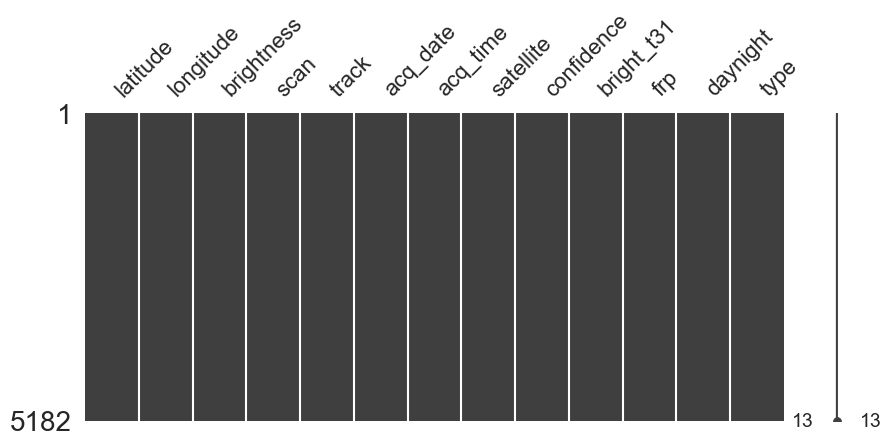

In [37]:
# Visualize missing values
msno.matrix(cleaned_data, figsize=(10, 4))
plt.show()

Check that the cleaned dataset was complete with no null values.

## Check Data Distributions

Density plots (Histogram) is used to examine the distribution of features, aiding in the detection of skewness, outliers, and transformations needed.

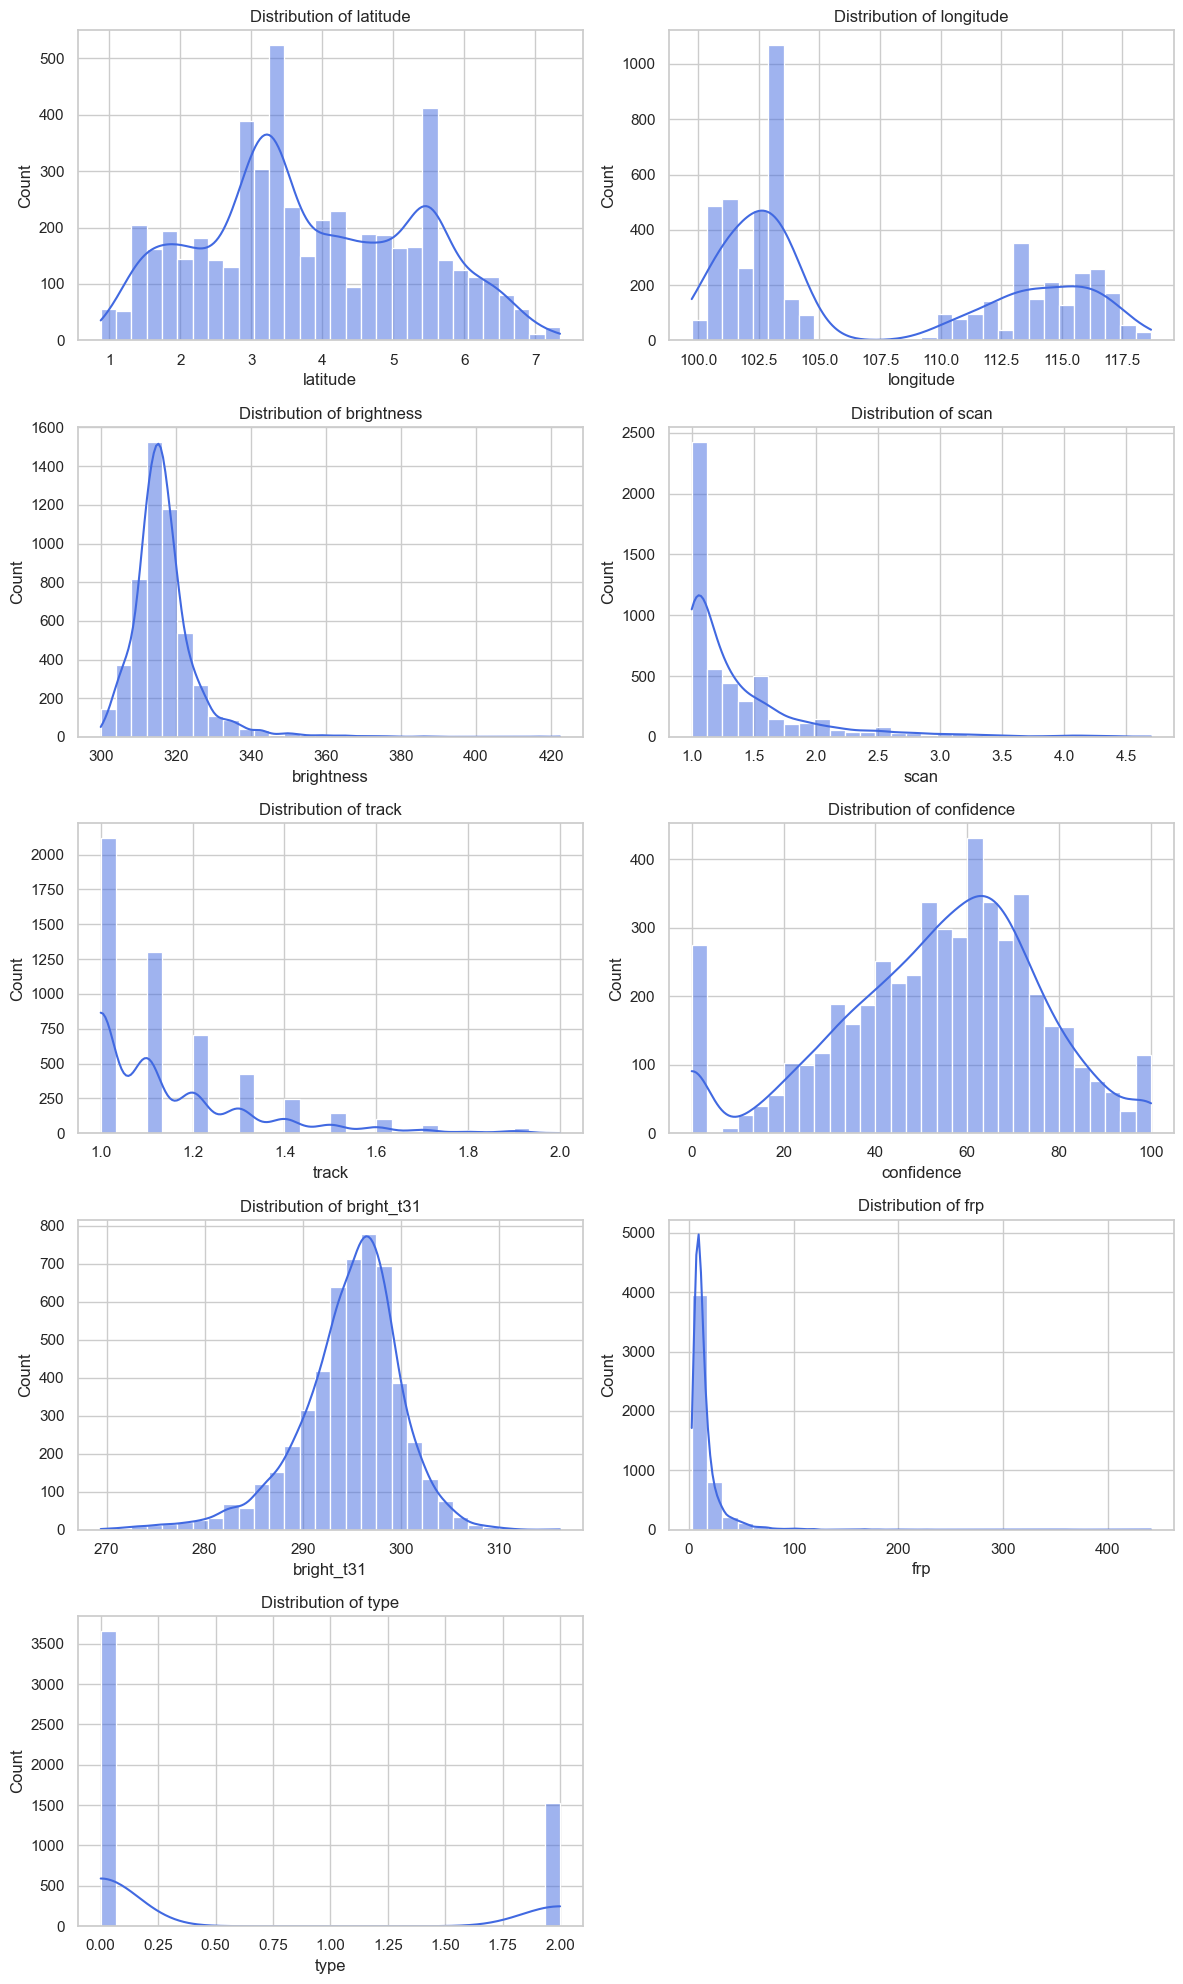

In [38]:
# Check Data Distributions for All Numeric Columns

# Set Seaborn style
sns.set(style="whitegrid")

# Automatically select all numeric columns
num_features_all = cleaned_data.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Create subplots: 2 per row
n_cols = 2
n_rows = int(np.ceil(len(num_features_all) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot each numeric column
for i, col in enumerate(num_features_all):
    sns.histplot(cleaned_data[col], bins=30, kde=True, ax=axes[i], color="royalblue")
    axes[i].set_title(f"Distribution of {col}")

# Hide any extra axes
for j in range(len(num_features_all), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Check Data Distributions (Selected Features)

Focused analysis on selected features relevant to clustering tasks (e.g., brightness, bright_t31, frp and confidence) to understand their value ranges and scaling needs. 

***This is not how we decide features for modeling. This is just for display purpose***

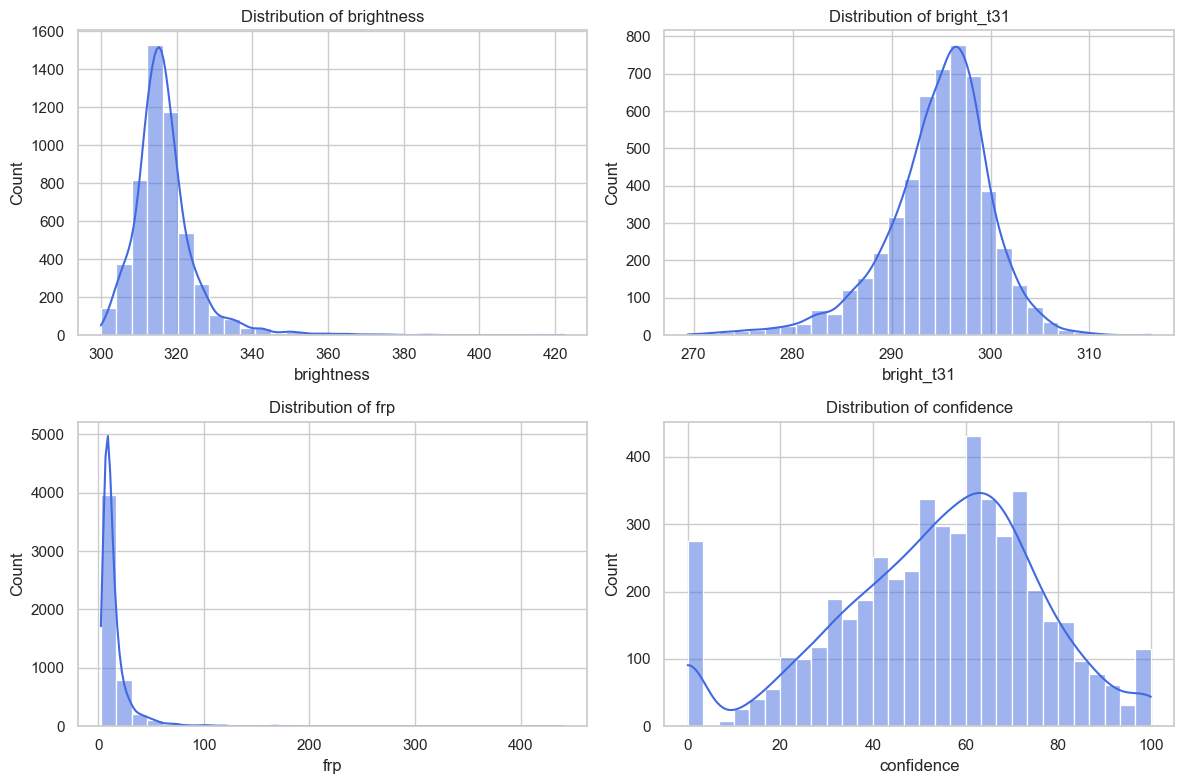

In [39]:
# Set Seaborn style
sns.set(style="whitegrid")

# Define numerical features
num_features = ["brightness", "bright_t31", "frp", "confidence"]

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(cleaned_data[col], bins=30, kde=True, ax=axes[i], color="royalblue")
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

Histograms and KDE plots were used to understand the distribution of core numerical features. For brightness, it is right-skewed which means most brightness values are between 310 and 330, with very few high outliers beyond 360. Typical fire events have moderate brightness; very intense fires are rare. For bright_t31, it has a nearly normal distribution that centers around 290k. It ranges from 270k to 310k. Thermal infrared brightness (from Band 31) is fairly stable and follows natural variation. For frp, it is highly right-skewed where most values are very low (<50), but there are a few extreme values up to 400+. Most fires release little energy, but there are some rare, very high-energy fire events.For confidence, it is somewhat multimodal or uneven, which means that the values are spread out, with spikes at 0, 50-80 and 100. Confidence values may be categorical or bucketed, not continuous. Spikes at round numbers suggest pre-defined categories (e.g., low, nominal, high).

## Check for Outliers Using Boxplots

Boxplots highlight outliers across all features to assess data integrity and decide on handling strategies.

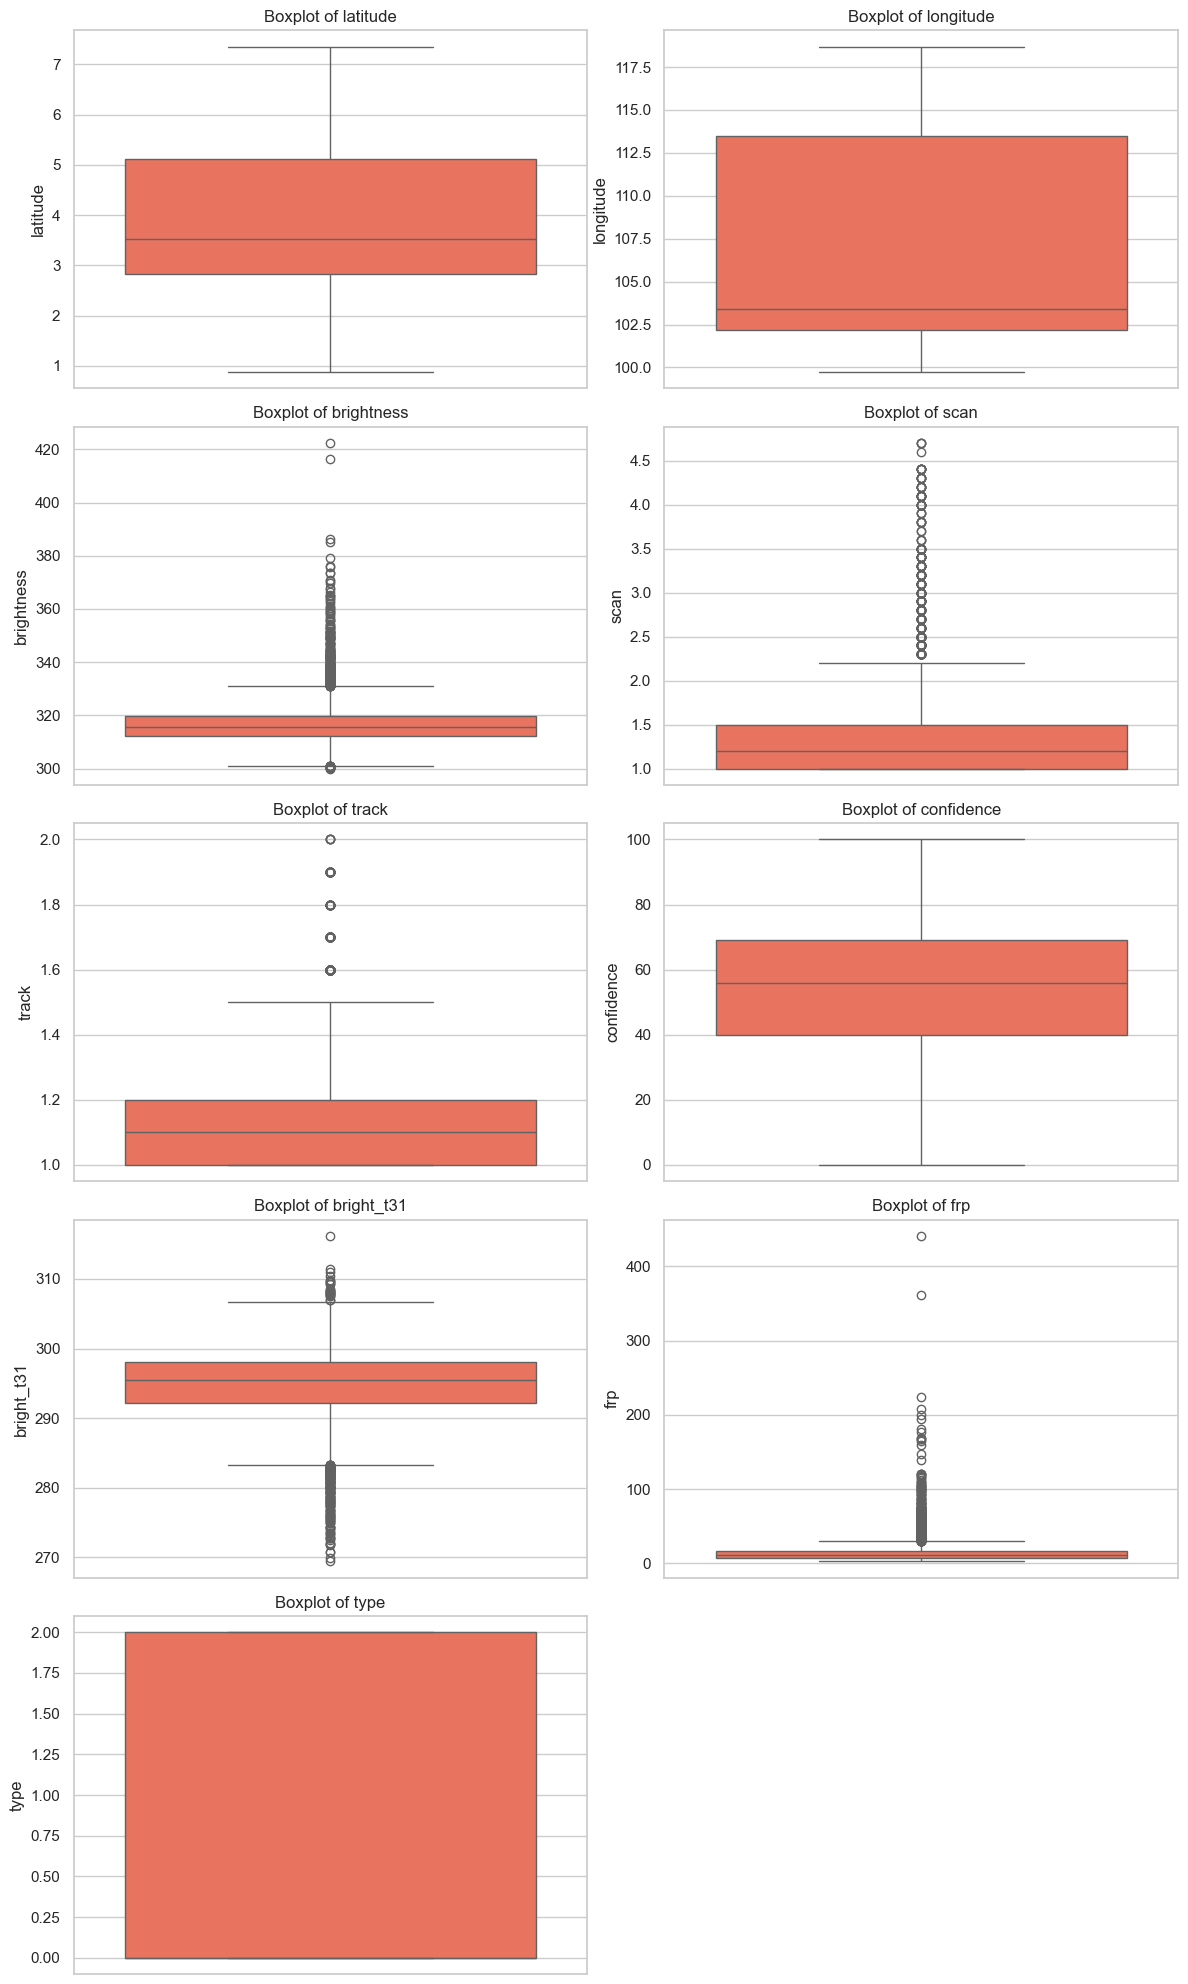

In [40]:
# Select all numeric columns
num_features_all = cleaned_data.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Create subplots: 2 boxplots per row
n_cols = 2
n_rows = int(np.ceil(len(num_features_all) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot each boxplot
for i, col in enumerate(num_features_all):
    sns.boxplot(y=cleaned_data[col], ax=axes[i], color="tomato")
    axes[i].set_title(f"Boxplot of {col}")

# Remove any unused axes
for j in range(len(num_features_all), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Check for Outliers Using Boxplots (Selected Features)

Outlier inspection zoomed into key clustering features to see if extreme values may bias the clustering results.

***This is not how we decide features for modeling. This is just for display purpose***

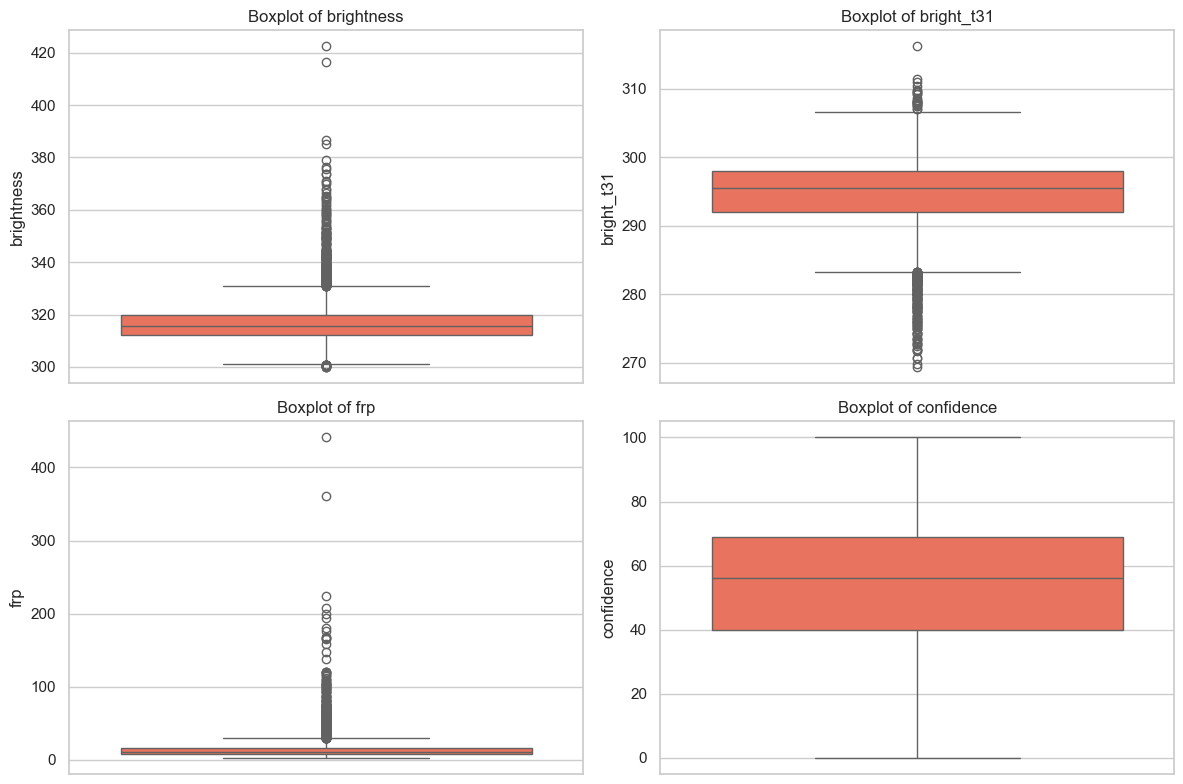

In [41]:
# Plot boxplots to identify outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(y=cleaned_data[col], ax=axes[i], color="tomato")
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

The boxplots presented provide a visual summary of the distribution and variability of four different variables: brightness, bright_t31, frp, and confidence. Starting with brightness, the data is tightly clustered around the median with a few high-value outliers extending up to around 420. This indicates that while most values are consistent, there are occasional spikes in brightness. Similarly, bright_t31, which may represent a temperature-related measure, also shows a relatively narrow interquartile range (IQR), with a slightly higher median than brightness and fewer extreme outliers. In contrast, the frp (Fire Radiative Power) boxplot reveals a highly skewed distribution with a large number of extreme outliers, suggesting that while most frp values are low, there are occasional intense fire events that dramatically increase the readings. Finally, the confidence variable, likely reflecting the model or measurement certainty, spans a wider range from 0 to 100, with a more balanced distribution, a median around 60, and a relatively symmetrical spread. Overall, the plots reveal that most variables have compact distributions with several significant outliers, especially in brightness and frp.

## Correlation Heatmap

Relationships between numerical features are assessed. The correlation heatmap is used to visualize the strength and direction of linear relationships between numerical variables. In the context of clustering, it helps us understand how features co-vary, guiding decisions on feature selection or transformation.


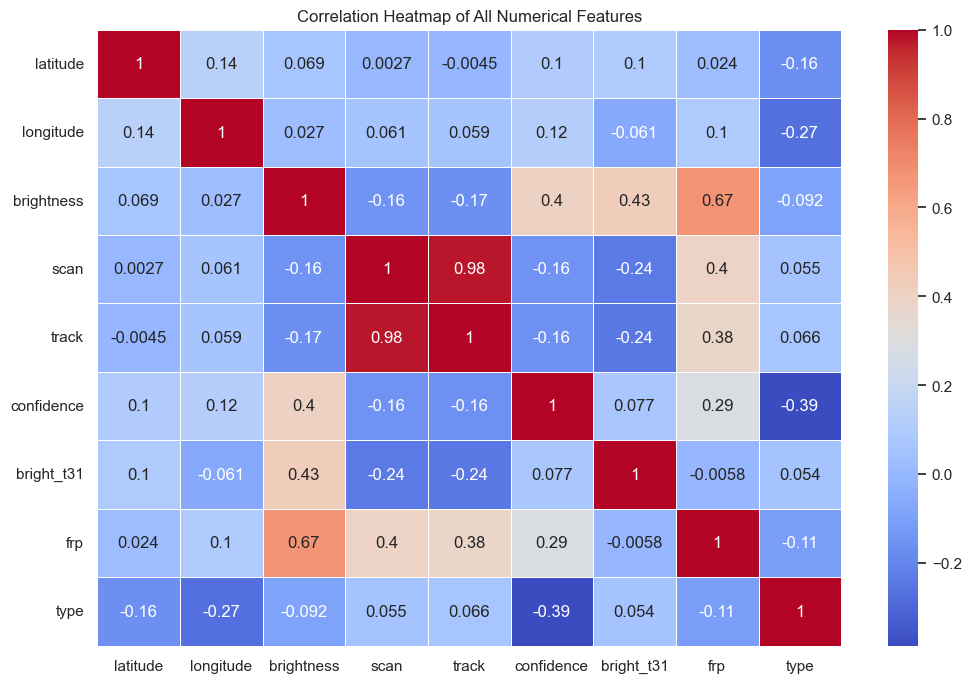

In [42]:
# Select all numerical features in the cleaned dataset
numerical_cols = cleaned_data.select_dtypes(include=["float64", "int64"]).columns

# Compute and visualize correlation matrix for all numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(cleaned_data[numerical_cols].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of All Numerical Features")
plt.show()

The correlation heatmap displays the pairwise Pearson correlation coefficients between all numerical features in the dataset. The values range from -1 to 1, where 1 indicates a perfect positive correlation, -1 a perfect negative correlation, and 0 no correlation at all. Notably, scan and track show an extremely high positive correlation (0.98), suggesting they capture very similar or related spatial data. There is also a strong positive correlation between brightness and frp (0.67), implying that higher brightness values are typically associated with increased Fire Radiative Power—logical given their physical relationship in fire detection. A moderate correlation (0.43) is also seen between brightness and bright_t31, indicating some degree of association, though not as strong. On the other hand, features like latitude, longitude, and type generally show low or negative correlations with most other features, suggesting minimal linear relationship. Interestingly, confidence has weak to moderate correlations with several variables, and it is negatively correlated with type (-0.39), hinting that confidence levels might vary depending on the type classification in the dataset. Overall, the heatmap helps in identifying strongly correlated pairs and variables that are likely to contribute redundant information in modeling or analysis.

# Scatterplot Matrix with Correlation Coefficients (Selected Features)

This matrix visualizes pairwise relationships between selected features and helps identify clusters or collinearities.

***This is not how we decide features for modeling. This is just for display purpose***

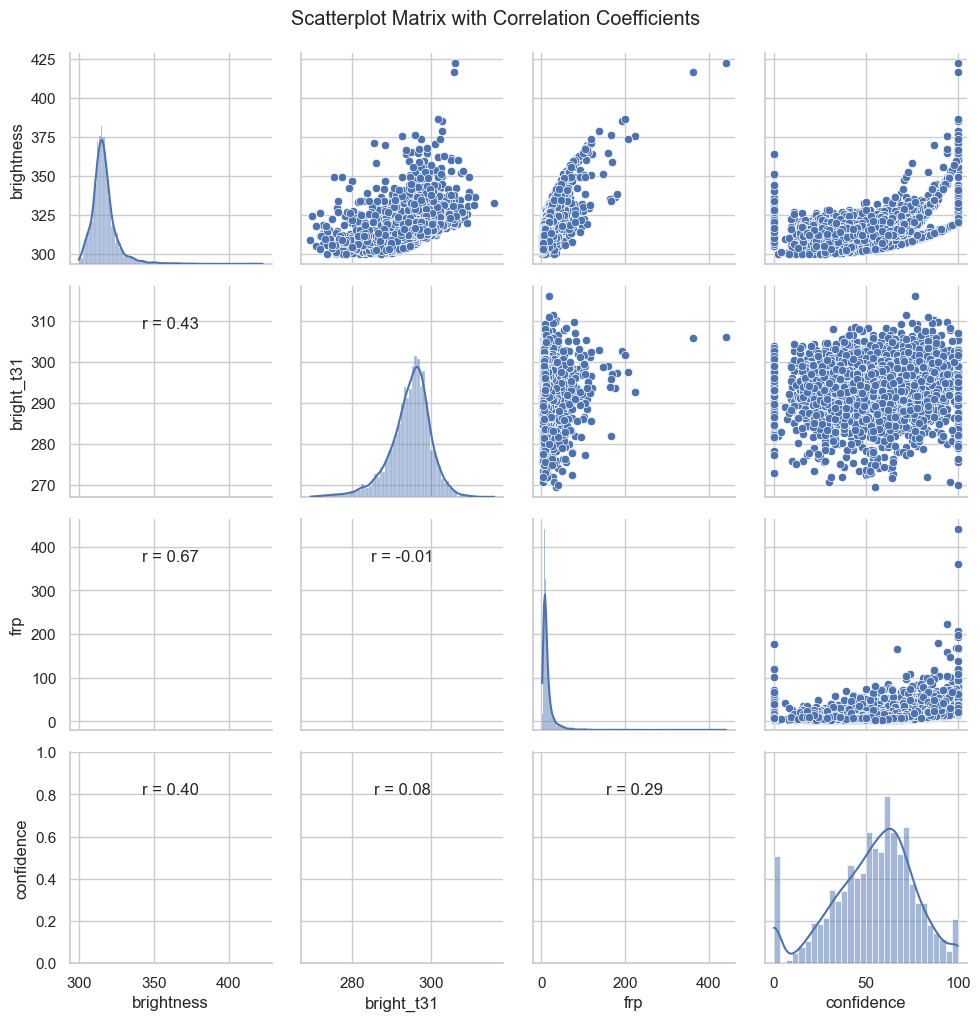

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def corrfunc(x, y, **kwargs):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(f"r = {r:.2f}", xy=(.5, .8), xycoords=ax.transAxes, ha='center')

# Use seaborn's PairGrid
g = sns.PairGrid(cleaned_data[["brightness", "bright_t31", "frp", "confidence"]])
g.map_upper(sns.scatterplot)
g.map_lower(corrfunc)
g.map_diag(sns.histplot, kde=True)
plt.suptitle("Scatterplot Matrix with Correlation Coefficients", y=1.02)
plt.show()

This code visualizes the relationships and correlations among selected numeric variables (brightness, bright_t31, frp, and confidence)rom a dataset called cleaned_data. It uses Seaborn's PairGrid to create a scatterplot matrix (also called a pair plot) with correlation coefficients shown in the lower triangle. brightness is right-skewed, with most values clustered around 310–340. bright_t31 is roughly normally distributed, centered near 290. frp is heavily skewed right, meaning most fires are low intensity. confidence is somewhat bimodal or spread, possibly due to categorization. For the scatterplots between pairs of variables, we can use it to spot the trends, clusters or outliers of the variables. For example, brightness vs frp: visible positive relationship; frp vs confidence: lots of spread, but some upward tendency. The r in the diagrams show Pearson correlation coefficients between variables that ranges from -1 to +1, representing perfect negative correlation to perfect positive correlation.

## Log Transformation for Outlier Handling

Log transformation is applied to reduce skewness and handle extreme values, improving model stability during clustering.

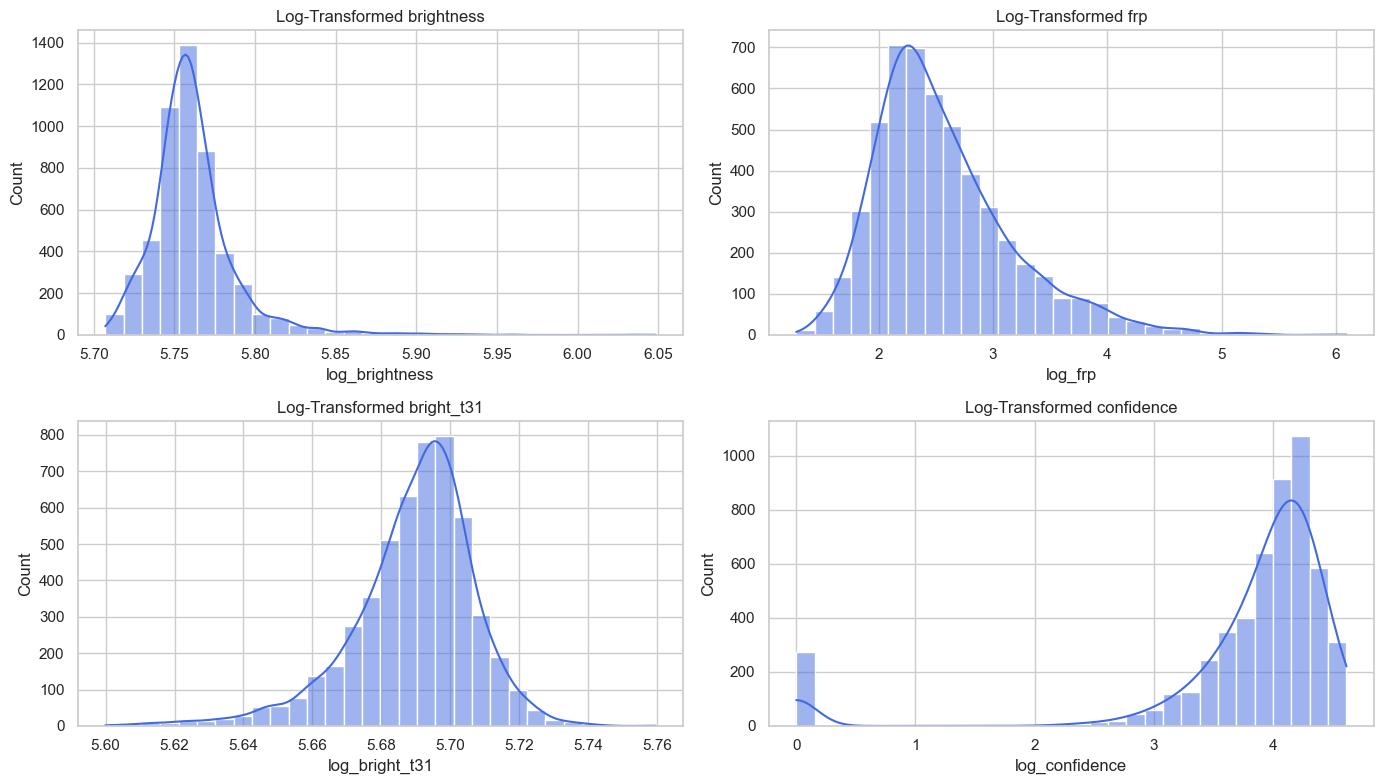

In [45]:
# Apply log transformation (adding 1 to avoid log(0))
log_transformed_data = cleaned_data.copy()
log_features = ["brightness", "frp", "bright_t31", "confidence"]

for feature in log_features:
    log_transformed_data[f"log_{feature}"] = np.log1p(log_transformed_data[feature])

# Create subplots based on number of features
n_cols = 2
n_rows = int(np.ceil(len(log_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

# Plot distributions
for i, feature in enumerate(log_features):
    sns.histplot(log_transformed_data[f"log_{feature}"], bins=30, kde=True, ax=axes[i], color="royalblue")
    axes[i].set_title(f"Log-Transformed {feature}")

# Hide any unused axes (if total subplots > features)
for j in range(len(log_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The log-transformed distribution plots illustrate how log transformation has helped normalize the skewed distributions of four key variables: brightness, frp, bright_t31, and confidence. Starting with log_brightness, the distribution appears more symmetric and bell-shaped after transformation, suggesting the data now approximates a normal distribution. Log_frp, which originally showed strong right-skew due to extreme outliers, now has a more compressed and smoother distribution, although a slight skew remains. The log_bright_t31 values display a nearly perfect normal curve, indicating the transformation was highly effective at correcting the original skew. Lastly, log_confidence shows a bimodal pattern, reflecting two distinct confidence levels even after transformation—possibly due to categorical-like behavior or discrete clusters in the original data. Overall, these log transformations have successfully reduced skewness, improved normality, and prepared the data for modeling techniques that assume normally distributed input features.

# PCA-Based Feature Importance

PCA is used to assess the variance explained by each feature, helping us identify which features are most informative for clustering.

Log transformation is applied before PCA to reduce skewness and stabilize variance in the data. Many real-world datasets, especially those involving physical measurements like brightness or fire radiative power (FRP), exhibit right-skewed distributions with extreme outliers. PCA assumes that the input data is normally distributed (or at least symmetric) to accurately capture the directions of maximum variance.

By applying log transformation first:
- We **compress the range** of values, making extreme values less dominant.
- We **reduce the influence of outliers**, which can otherwise distort PCA components.
- We **normalize the data distribution**, improving the interpretability and stability of the PCA results.

This preprocessing step ensures that the principal components represent meaningful underlying structure rather than being biased by highly skewed or large-magnitude values.


***This is how we decide features for modeling.***


🔹 PCA Component Loadings (Feature Importance):


,PC1,PC2
log_brightness,0.689490,0.051758
log_frp,0.566935,0.581082
log_bright_t31,0.391993,-0.733826
log_confidence,0.222554,-0.348085


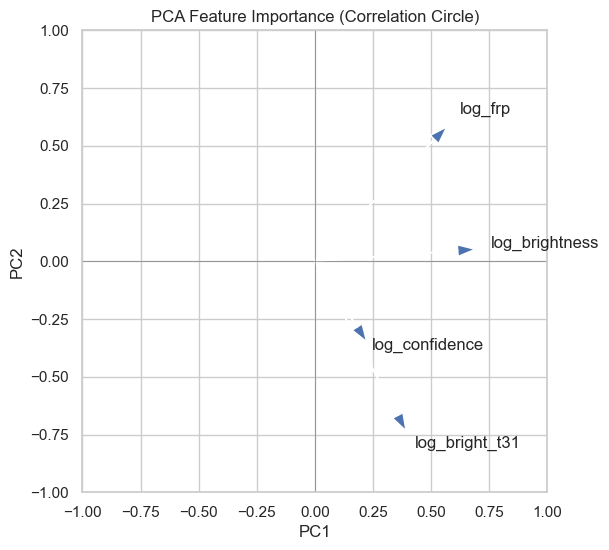

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Apply PCA on log-transformed and scaled features
pca_features = ["log_brightness", "log_frp", "log_bright_t31", "log_confidence"]

# Standardize again just to ensure clean PCA
scaler = StandardScaler()
scaled_pca_data = scaler.fit_transform(log_transformed_data[pca_features])

# Apply PCA
pca = PCA(n_components=2)
pca.fit(scaled_pca_data)

# Create a DataFrame for PCA loadings (feature importance)
pca_components = pd.DataFrame(
    pca.components_.T,
    index=pca_features,
    columns=["PC1", "PC2"]
)

print("\n🔹 PCA Component Loadings (Feature Importance):")
display(pca_components)

# Optional: Plot feature contributions visually
plt.figure(figsize=(6, 6))
for feature in pca_features:
    plt.arrow(0, 0,
              pca_components.loc[feature, "PC1"],
              pca_components.loc[feature, "PC2"],
              head_width=0.05, length_includes_head=True)
    plt.text(pca_components.loc[feature, "PC1"] * 1.1,
             pca_components.loc[feature, "PC2"] * 1.1,
             feature, fontsize=12)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Feature Importance (Correlation Circle)")
plt.grid(True)
plt.show()

This image presents the results of a Principal Component Analysis (PCA) on a dataset containing four log-transformed features: log_brightness, log_frp, log_bright_t31, and log_confidence. The top portion shows the PCA component loadings, which indicate the contribution of each feature to the first two principal components (PC1 and PC2). For PC1, the most influential features are log_brightness (0.689490) and log_frp (0.566935), suggesting that these variables primarily drive the variation captured along this axis. In contrast, PC2 is dominated by log_bright_t31 (-0.733826) and log_frp (0.581082), with log_bright_t31 contributing strongly in the negative direction. Accompanying this table, the PCA correlation circle plot (also known as a PCA biplot focused on feature loadings) visually illustrates the importance and relationships of the features in the reduced-dimensional space. In this plot, each arrow represents a log-transformed and scaled feature, where the direction and length of the arrow indicate both the axis along which the feature contributes and the strength of that contribution. Features like log_brightness and log_frp point primarily along the PC1 axis, reflecting their strong influence on that component, while log_bright_t31 points in the negative direction of PC2, confirming its high loading on that axis. The length of each arrow corresponds to the magnitude of a feature’s influence—longer arrows denote stronger contributions. Additionally, the angles between arrows reveal correlations: features pointing in similar directions, such as log_frp and log_brightness, are positively correlated, while features pointing in opposite directions, like log_frp and log_confidence, may be negatively correlated. Arrows at right angles suggest uncorrelated features. Altogether, the loadings table and correlation circle provide a comprehensive view of which features are most important in explaining variance in the dataset and how they relate to each principal component and to each other.



From the PCA results, we aim to select features that contribute strongly to the principal components—especially PC1, which captures the highest variance in the data.

✅ log_brightness and log_frp:
- These two features have the highest loadings on PC1 (0.689 and 0.567 respectively), indicating they are the most influential in explaining the primary variance of the dataset.
- In the correlation circle, they are located farthest from the origin, suggesting strong representation in the principal component space and good discriminatory power for clustering.

❌ log_bright_t31 and log_confidence:
- These features show weaker contributions to PC1 (0.392 and 0.223), and significant loading on PC2 (especially `log_bright_t31` with -0.73), indicating they contribute to less dominant patterns in the data.
- In the correlation circle, their shorter vector lengths and directions imply less relevance to the main clustering structure.

👉 Conclusion:
`log_brightness` and `log_frp` were chosen because they are both highly correlated with PC1, making them the most informative features for distinguishing patterns. Meanwhile, `log_confidence` and `log_bright_t31` were excluded to reduce noise and avoid introducing less meaningful dimensions into the clustering process.


## Feature Scaling for Clustering

Feature scaling (e.g., StandardScaler) is performed to ensure equal weighting in distance-based clustering methods. Feature scaling is essential when preparing data for Principal Component Analysis (PCA) because PCA is sensitive to the variances of the original features. If features are on different scales, those with larger ranges will dominate the principal components, potentially skewing the analysis and leading to misleading results.

By standardizing features so that they have a mean of zero and a standard deviation of one, we ensure that each variable contributes equally to the PCA. This allows the algorithm to identify directions of maximum variance based on the intrinsic structure of the data, rather than being biased by the original units or magnitudes of the variables.

In [48]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features_for_clustering = ["log_brightness", "log_frp"]

# Apply StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(log_transformed_data[features_for_clustering])

# Convert back to DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features_for_clustering)

# Display first few rows of scaled data
print("🔹 Scaled Features Preview:")
display(scaled_data.head())

# Check mean and variance after scaling
print("\n🔹 Feature Mean After Scaling:")
display(scaled_data.mean())
print("\n🔹 Feature Standard Deviation After Scaling:")
display(scaled_data.std())

🔹 Scaled Features Preview:


,log_brightness,log_frp
0,0.177222,0.132607
1,-0.684282,-1.051535
2,0.318915,0.048235
3,1.007939,0.120814
4,0.354255,-0.387725



🔹 Feature Mean After Scaling:


log_brightness    2.378714e-14
log_frp          -5.484699e-17
dtype: float64


🔹 Feature Standard Deviation After Scaling:


log_brightness    1.000097
log_frp           1.000097
dtype: float64

This code displays the results of feature scaling applied to two variables: log_brightness and log_frp. The "Scaled Features Preview" section shows the first few rows of the dataset after standardization, where values have been transformed to have a mean near zero and a standard deviation near one. This is confirmed by the "Feature Mean After Scaling" section, where the means for both features are extremely close to zero (on the order of 10⁻¹⁴ and 10⁻¹⁷), which aligns with expectations for standardized data.

The "Feature Standard Deviation After Scaling" section further validates successful standardization: both log_brightness and log_frp have standard deviations of approximately 1.000097, indicating that the data has been scaled correctly. This standardization step is crucial before applying PCA, as it ensures that each feature contributes equally to the analysis, regardless of their original scales.

# GMM: Silhouette Score vs Number of Clusters

This section tests Gaussian Mixture Models (GMM) with varying cluster counts and uses the Silhouette Score to evaluate clustering quality. The goal is to identify the number of clusters that best separates the data based on probability distributions rather than hard boundaries, as in k-means.

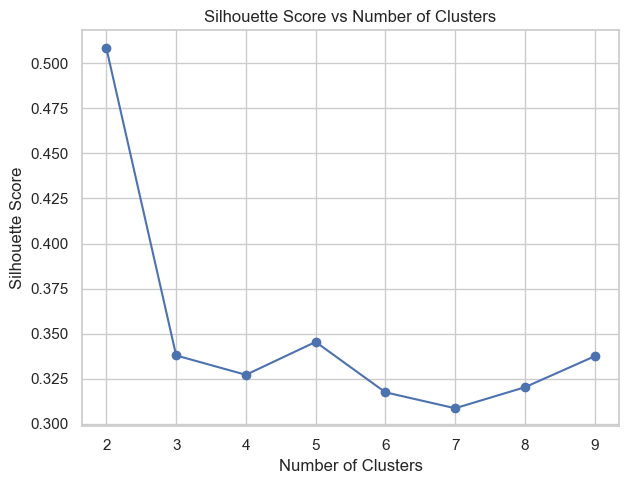

In [49]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = list(range(2, 10))
gmm_silhouette_scores = []
gmm_log_likelihoods = []

for n in range_n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm_labels = gmm.fit_predict(scaled_data[features_for_clustering])
    gmm_silhouette_scores.append(silhouette_score(scaled_data[features_for_clustering], gmm_labels))
    gmm_log_likelihoods.append(gmm.score(scaled_data[features_for_clustering]))

# Plot Silhouette Scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, gmm_silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

The graph shows the relationship between the number of Gaussian Mixture Model (GMM) components and the corresponding silhouette scores, which measure how well the data points fit within their assigned clusters. From the plot, we can observe that the silhouette score is highest when using 2 components, with a value slightly above 0.50, indicating a strong clustering structure.

As the number of components increases beyond 2, the silhouette score drops sharply and fluctuates around 0.30 to 0.35, suggesting weaker and less well-defined clusters. There is a small peak at 5 components, but it is still significantly lower than the score for 2 components.

This trend suggests that the optimal number of GMM components for this dataset is likely 2, as it provides the best-defined clustering according to the silhouette score. Adding more components may lead to overfitting or capturing noise, rather than meaningful structure.

# Spectral Clustering: Silhouette Score vs Number of Clusters

Spectral Clustering is applied here with different cluster numbers to assess how well it captures non-convex cluster structures. The Silhouette Score helps determine the optimal number of clusters by measuring intra-cluster cohesion and inter-cluster separation.


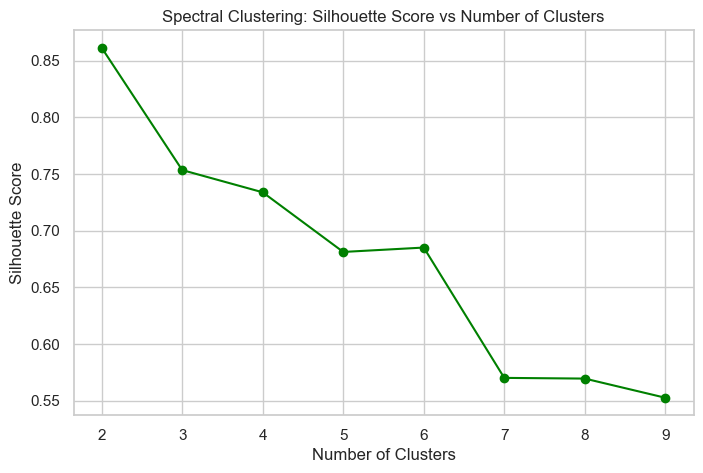

In [50]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

spectral_silhouette_scores = []
n_clusters_range = range(2, 10)

for n_clusters in n_clusters_range:
    try:
        spectral = SpectralClustering(
            n_clusters=n_clusters,
            affinity='rbf',
            assign_labels='kmeans',
            random_state=42
        )
        labels = spectral.fit_predict(scaled_data[features_for_clustering])
        
        # Only compute silhouette score if multiple clusters are found
        if len(set(labels)) > 1:
            score = silhouette_score(scaled_data[features_for_clustering], labels)
        else:
            score = -1  # Assign dummy score if only one cluster found
        spectral_silhouette_scores.append(score)
        
    except Exception as e:
        print(f"Spectral clustering failed for n_clusters={n_clusters}: {e}")
        spectral_silhouette_scores.append(-1)  # Assign placeholder for failure

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, spectral_silhouette_scores, marker='o', color='green')
plt.title("Spectral Clustering: Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

The graph illustrates the relationship between the number of clusters and the Silhouette Score in Spectral Clustering. As shown, the Silhouette Score is highest when the number of clusters is 2, with a value above 0.85, indicating well-defined and well-separated clusters. As the number of clusters increases, the Silhouette Score gradually declines, suggesting that the quality of the clustering decreases. This trend is especially noticeable after six clusters, where the score drops more steeply, reaching around 0.55 at nine clusters. Overall, the plot suggests that using two clusters yields the most cohesive and separated groupings in this dataset, making it the optimal choice according to the Silhouette Score.

# Fuzzy C-Means: Silhouette Score vs Number of Clusters

This step evaluates Fuzzy C-Means clustering with various cluster sizes. Since FCM allows data points to belong to multiple clusters with varying degrees, the Silhouette Score helps assess how well-defined and meaningful the clusters are despite this overlap.

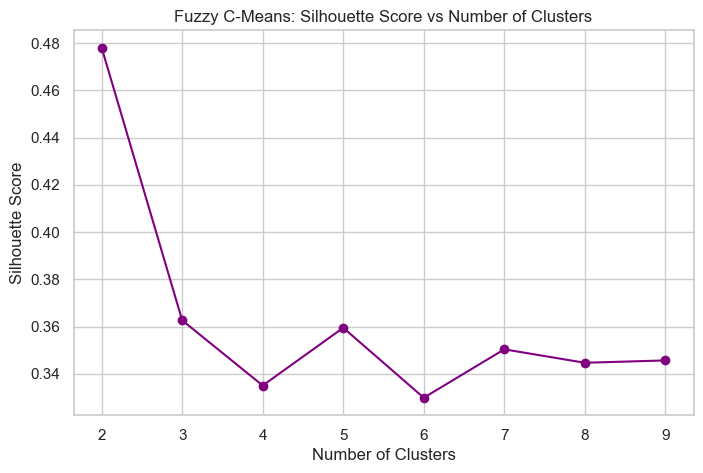

In [51]:
import skfuzzy as fuzz
import numpy as np

fcm_silhouette_scores = []
cluster_range = range(2, 10)

for c in cluster_range:
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        scaled_data[features_for_clustering].T,
        c,
        m=2,
        error=0.005,
        maxiter=1000,
        init=None
    )
    cluster_labels = np.argmax(u, axis=0)
    score = silhouette_score(scaled_data[features_for_clustering], cluster_labels)
    fcm_silhouette_scores.append(score)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, fcm_silhouette_scores, marker='o', color='purple')
plt.title("Fuzzy C-Means: Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

The graph presents the Silhouette Score as a function of the number of clusters for the Fuzzy C-Means clustering algorithm. The highest Silhouette Score is observed when the number of clusters is 2, with a value close to 0.48, indicating that the clustering is most effective at this point in terms of intra-cluster cohesion and inter-cluster separation. As the number of clusters increases beyond two, the Silhouette Score declines and fluctuates, with values mostly remaining between 0.32 and 0.36. This suggests that increasing the number of clusters leads to less distinct groupings, possibly due to overlapping or less compact clusters. Overall, the results imply that Fuzzy C-Means clustering performs best with two clusters for this dataset, though its performance is generally weaker compared to Spectral Clustering, as seen in the previous plot.

# Elbow Method for Fuzzy C-Means

The Elbow Method is used here to determine the ideal number of clusters in Fuzzy C-Means by plotting the cost function (e.g., within-cluster sum of distances) against the number of clusters. The “elbow” point, where improvement drops off, suggests the optimal cluster count.


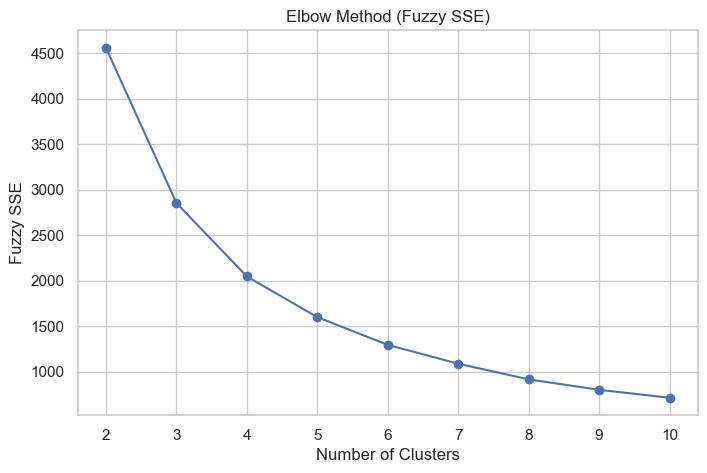

In [52]:
# Fuzzy SSE calculation for different cluster counts
sse_results = []
# Re-define the feature matrix for FCM
X_fcm = scaled_data[["log_brightness", "log_frp"]].values.T  # Transpose for skfuzzy
best_m = 1.5  # or 2.0 / 2.5 depending on your best value



for c in range(2, 11):
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        X_fcm, c, m=best_m, error=0.005, maxiter=1000, init=None, seed=42
    )

    # Compute fuzzy SSE (weighted squared distances)
    distances = np.zeros((c, X_fcm.shape[1]))
    for i in range(c):
        distances[i] = np.linalg.norm(X_fcm.T - cntr[i], axis=1) ** 2
    weighted_sse = np.sum(u**2 * distances)

    sse_results.append(weighted_sse)

# Plot Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sse_results, marker="o")
plt.title("Elbow Method (Fuzzy SSE)")
plt.xlabel("Number of Clusters")
plt.ylabel("Fuzzy SSE")
plt.grid(True)
plt.show()


The graph displays the Elbow Method for Fuzzy C-Means clustering using the Fuzzy Sum of Squared Errors (SSE) as the evaluation metric for determining the optimal number of clusters. The curve shows a clear "elbow" at around 3 clusters, where the steep decline in SSE begins to level off. This indicates that beyond 3 clusters, the reduction in within-cluster variance becomes marginal, suggesting that 3 might be the optimal number of clusters from a purely mathematical standpoint, balancing clustering compactness and model complexity.

However, despite the elbow's position at 3, we have chosen to use 2 clusters based on strong domain relevance and practical interpretability. While the Elbow Method and related metrics may point toward a slightly higher number of clusters, our decision prioritizes real-world applicability over marginal improvements in SSE. The dataset naturally divides into two meaningful categories: low-intensity and high-intensity fire events. This binary classification aligns directly with practical needs in areas such as disaster response, satellite-based fire monitoring, and policy-making, where a simple yet meaningful distinction is often more valuable than a complex clustering structure.

Moreover, adopting 2 clusters enhances interpretability without sacrificing the ability to capture subtle variations. Thanks to the fuzzy nature of the clustering algorithm, each data point retains a degree of membership to both clusters, allowing us to model intensity as a gradient (e.g., 70% low-intensity, 30% high-intensity). This reflects the inherent uncertainty and variability in real-world fire events more effectively than hard clustering would. In addition, key clustering validity metrics support this choice: the Partition Coefficient (PC) was highest and the Partition Entropy (PE) lowest when the number of clusters was set to 2, indicating strong cluster separation and confident membership assignments. Thus, although the Elbow Method suggests 3 clusters as optimal in terms of SSE, the use of 2 clusters provides a better balance between interpretability, domain significance, and fuzzy clustering strengths.

# Fuzzy C-Mean : Partition Coefficient (PC) and Partition Entropy (PE)

Partition Coefficient (PC) and Partition Entropy (PE) are evaluated across different cluster counts to assess the quality of fuzzy clustering. Higher PC and lower PE values indicate better-defined, more confident fuzzy memberships, guiding the choice of cluster number.

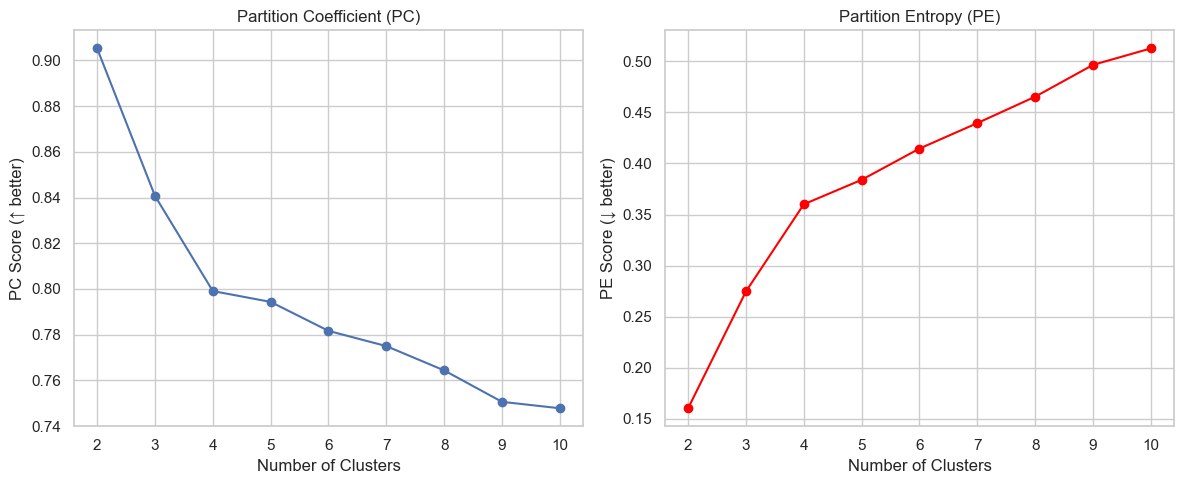

In [53]:
def partition_coefficient(u):
    return np.sum(u**2) / u.shape[1]

def partition_entropy(u):
    return -np.sum(u * np.log(u + 1e-10)) / u.shape[1]

pc_scores = []
pe_scores = []

for c in range(2, 11):
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        X_fcm, c, m=best_m, error=0.005, maxiter=1000, init=None, seed=42
    )
    pc_scores.append(partition_coefficient(u))
    pe_scores.append(partition_entropy(u))

# Plot PC and PE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), pc_scores, marker="o")
plt.title("Partition Coefficient (PC)")
plt.xlabel("Number of Clusters")
plt.ylabel("PC Score (↑ better)")

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), pe_scores, marker="o", color="red")
plt.title("Partition Entropy (PE)")
plt.xlabel("Number of Clusters")
plt.ylabel("PE Score (↓ better)")

plt.tight_layout()
plt.show()


These two line graphs are used to evaluate the optimal number of clusters in a fuzzy clustering algorithm by analyzing two key internal validation metrics: the Partition Coefficient (PC) and Partition Entropy (PE). These metrics help assess the clarity and confidence of cluster assignments across different values of 𝑐, the number of clusters.

The left graph plots the Partition Coefficient (PC) score against the number of clusters. In fuzzy clustering, a higher PC score (closer to 1) indicates that data points are more confidently assigned to clusters, meaning the clustering structure is more well-defined and less ambiguous. In this plot, the PC score is highest at 2 clusters, after which it drops sharply between 2 and 4 clusters, and then continues to decline more gradually. This suggests that the separation between clusters becomes less distinct as more clusters are added. The steep initial decline indicates that the most significant drop in clustering clarity happens early, reinforcing that 2 clusters yield the most distinct and clean separation of the data.

The right graph shows the Partition Entropy (PE) score, where lower values (closer to 0) represent less uncertainty or fuzziness in the clustering results. As the number of clusters increases, the PE score rises steadily, indicating increasing ambiguity in the cluster assignments. Notably, the lowest PE score occurs at 2 clusters, confirming that the separation between clusters is most confident and least fuzzy when only two groups are used. This highlights that 2 clusters result in the cleanest partitioning, with minimal overlap or uncertainty in membership degrees.

Although there appears to be a potential balance point around 3 or 4 clusters — where the PC has not yet completely flattened and the PE is still relatively low — the combination of highest PC and lowest PE at 2 clusters strongly suggests that this is the most distinct and interpretable clustering configuration. In other words, while additional clusters may offer finer granularity, they do so at the cost of increased fuzziness and reduced confidence in cluster assignments. This is particularly important in real-world applications where clarity, simplicity, and interpretability are prioritized — such as distinguishing between low-intensity and high-intensity fire events. Therefore, 2 clusters not only provide the cleanest mathematical separation but also align best with practical classification needs.

# Elbow Method for Hierarchical Clustering

This section uses the Elbow Method to determine the appropriate number of clusters for Hierarchical Clustering by analyzing linkage distances. A noticeable jump in distances (the “elbow”) suggests a natural grouping level in the data.

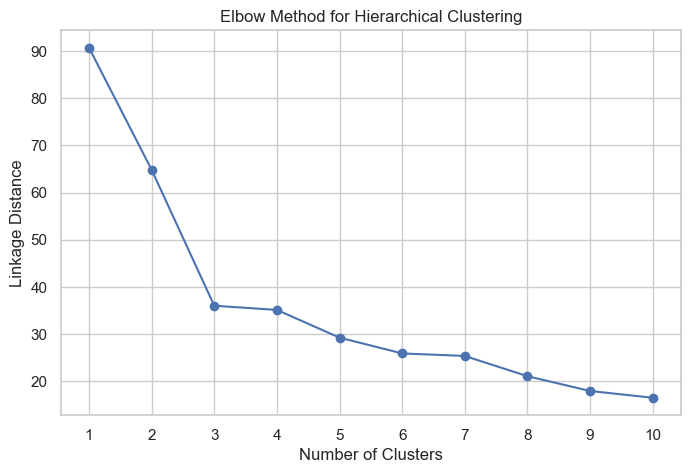

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

# Step 1: Perform linkage (if not already done)
Z = linkage(scaled_data[["log_brightness", "log_frp"]], method='ward')

# Step 2: Extract distances (the height of merges)
last_merges = Z[-10:, 2]  # Last 10 merge distances (from largest to smallest)
num_clusters_range = range(1, 11)  # Corresponding number of clusters (reverse)

# Step 3: Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(num_clusters_range, last_merges[::-1], marker='o')
plt.title("Elbow Method for Hierarchical Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Linkage Distance")
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

The image shows a plot of the Elbow Method for Hierarchical Clustering, which is used to determine the optimal number of clusters by analyzing the linkage distance as clusters are merged. On the y-axis is the Linkage Distance, a measure of the dissimilarity between merged clusters, and on the x-axis is the Number of Clusters.

The curve starts with a steep decline from 1 to 3 clusters, indicating that merging clusters in this range significantly reduces dissimilarity. After 3 clusters, the decrease in linkage distance becomes more gradual, forming an "elbow" shape around 3 clusters. This elbow suggests that adding more clusters beyond this point results in only marginal improvement in the compactness or separation of clusters. Therefore, the optimal number of clusters based on this plot is likely 3, as it balances minimizing dissimilarity while avoiding unnecessary complexity.

# GMM

GMM is used to model the data as a mixture of several Gaussian distributions. Unlike k-means, GMM allows clusters to take on elliptical shapes and provides soft clustering (probabilistic membership). It is chosen to better capture complex cluster geometries and overlapping clusters that are not well-separated.


In [55]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Range of hyperparameters to try
n_components_range = range(2, 10)
covariance_types = ['full', 'tied', 'diag', 'spherical']
init_methods = ['kmeans', 'random']

# Store results
results = []

# Loop through all combinations
for n in n_components_range:
    for cov_type in covariance_types:
        for init in init_methods:
            try:
                gmm = GaussianMixture(n_components=n, covariance_type=cov_type, init_params=init, random_state=42)
                labels = gmm.fit_predict(scaled_data[features_for_clustering])
                sil_score = silhouette_score(scaled_data[features_for_clustering], labels)
                db_index = davies_bouldin_score(scaled_data[features_for_clustering], labels)
                ch_index = calinski_harabasz_score(scaled_data[features_for_clustering], labels)
                results.append({
                    "n_components": n,
                    "covariance_type": cov_type,
                    "init_params": init,
                    "silhouette_score": sil_score,
                    "davies_bouldin": db_index,
                    "calinski_harabasz": ch_index
                })
            except:
                continue

# Convert to DataFrame
gmm_results_df = pd.DataFrame(results)

# Show top 10 by silhouette score
top_gmm = gmm_results_df.sort_values(by="silhouette_score", ascending=False).head(10)
print("🔍 Top 10 GMM Configurations (by Silhouette Score):")
display(top_gmm)

🔍 Top 10 GMM Configurations (by Silhouette Score):


,n_components,covariance_type,init_params,silhouette_score,davies_bouldin,calinski_harabasz
2,2,tied,kmeans,0.563916,0.849839,3359.070394
3,2,diag,kmeans,0.554484,0.823881,4135.786336
4,2,diag,random,0.552462,0.829290,4125.800077
5,2,spherical,kmeans,0.552422,0.819986,4205.093259
6,2,spherical,random,0.546710,0.830740,4217.565812
0,2,full,kmeans,0.508281,1.007766,3063.598890
1,2,full,random,0.414128,1.971596,804.854342
17,4,tied,kmeans,0.413825,0.861447,2417.241608
9,3,tied,kmeans,0.412475,0.862773,2400.662427
13,3,spherical,kmeans,0.403400,0.891988,4321.529462


The Gaussian Mixture Model (GMM) clustering process was fine-tuned using an extensive grid search over multiple hyperparameters to identify the optimal configuration for clustering fire intensity data. Specifically, the number of components (n_components), covariance types (full, tied, diag, spherical), and initialization methods (kmeans, random) were varied systematically. For each combination, the model was trained and evaluated using three widely accepted clustering validation metrics: Silhouette Score (where a higher value indicates better-defined clusters), Davies-Bouldin Index (lower is better), and Calinski-Harabasz Index (higher is better). Results from all valid configurations were stored in a DataFrame, and the top-performing models were identified by ranking them based on the silhouette score. This comprehensive evaluation approach ensured that the final model selection was both data-driven and robust, capturing the most meaningful structure in the data while avoiding suboptimal or unstable configurations.

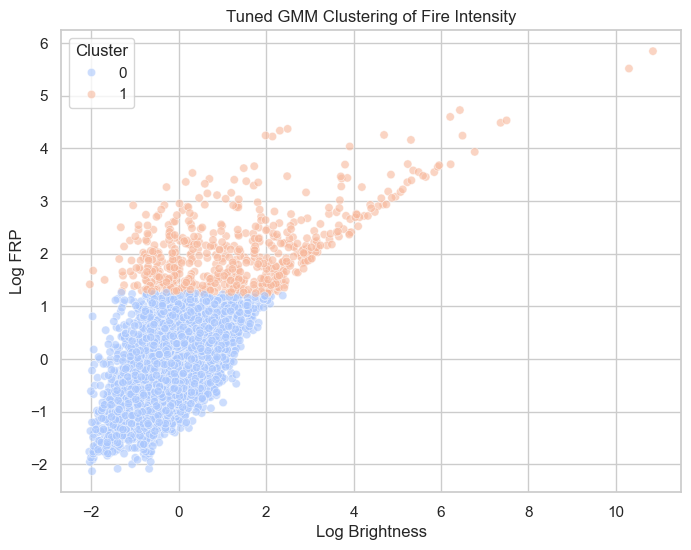

In [56]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Optimal parameters from tuning
best_gmm = GaussianMixture(
    n_components=2,
    covariance_type='tied',
    init_params='kmeans',
    random_state=42
)

# Fit and predict
gmm_labels = best_gmm.fit_predict(scaled_data[features_for_clustering])

# Add labels to DataFrame
scaled_data["gmm_cluster"] = gmm_labels

# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=scaled_data["log_brightness"],
    y=scaled_data["log_frp"],
    hue=gmm_labels,
    palette="coolwarm",
    alpha=0.6
)
plt.title("Tuned GMM Clustering of Fire Intensity")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Cluster")
plt.show()

The scatter plot shows the result of a Tuned Gaussian Mixture Model (GMM) Clustering applied to fire intensity data, using two features: Log Brightness on the x-axis and Log FRP (Fire Radiative Power) on the y-axis. The data points are color-coded by cluster assignment, with two clusters identified: Cluster 0 (blue) and Cluster 1 (orange).

From the plot, we observe that Cluster 1 (orange) primarily contains points with lower Log FRP values (below ~1.5), even when brightness varies, indicating relatively less intense fires. On the other hand, Cluster 0 (blue) includes points with higher Log FRP, corresponding to more intense fire events, especially at moderate to high brightness levels. The clustering captures a clear distinction in fire behavior based on intensity, and the decision boundary between the clusters seems nonlinear, which is well-suited for GMM’s probabilistic and flexible clustering capability. This model effectively separates fire events into two intensity-based categories, potentially aiding in targeted response or analysis.

# SOM

SOM is a type of neural network that projects high-dimensional data onto a lower-dimensional (usually 2D) grid while preserving topological relationships. It’s used to visualize the structure of the data and discover natural clusters without predefined labels. It’s selected for its ability to capture non-linear patterns and support intuitive cluster interpretation.


In [57]:
from minisom import MiniSom
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import numpy as np

# Set your scaled features
X = scaled_data[["log_brightness", "log_frp"]].values

# Define parameter ranges
grid_sizes = [(2, 2), (3, 2), (3, 3), (4, 3), (4, 4)]
sigmas = [0.5, 1.0, 1.5]
learning_rates = [0.1, 0.3, 0.5]

# Store results
som_results = []

for grid_rows, grid_cols in grid_sizes:
    for sigma in sigmas:
        for lr in learning_rates:
            som = MiniSom(grid_rows, grid_cols, X.shape[1], sigma=sigma, learning_rate=lr)
            som.random_weights_init(X)
            som.train_random(X, 200)

            # Get SOM labels
            labels = np.array([som.winner(x) for x in X])
            cluster_labels = np.array([r * grid_cols + c for r, c in labels])

            if len(np.unique(cluster_labels)) > 1:
                silhouette = silhouette_score(X, cluster_labels)
                db = davies_bouldin_score(X, cluster_labels)
                ch = calinski_harabasz_score(X, cluster_labels)
            else:
                silhouette, db, ch = None, None, None

            som_results.append({
                "grid_rows": grid_rows,
                "grid_cols": grid_cols,
                "sigma": sigma,
                "learning_rate": lr,
                "n_clusters": len(np.unique(cluster_labels)),
                "silhouette_score": silhouette,
                "davies_bouldin": db,
                "calinski_harabasz": ch
            })

# Convert to DataFrame and display best configs
som_results_df = pd.DataFrame(som_results)
top_som = som_results_df.sort_values(by="silhouette_score", ascending=False).head(10)

print("🔍 Top 10 SOM Configurations (by Silhouette Score):")
display(top_som)

🔍 Top 10 SOM Configurations (by Silhouette Score):


,grid_rows,grid_cols,sigma,learning_rate,n_clusters,silhouette_score,davies_bouldin,calinski_harabasz
11,3,2,0.5,0.5,6,0.347701,0.854651,3513.781304
10,3,2,0.5,0.3,6,0.334226,0.843712,3337.553826
1,2,2,0.5,0.3,4,0.330547,0.888025,3473.275488
0,2,2,0.5,0.1,4,0.318949,0.883735,3241.735960
28,4,3,0.5,0.3,12,0.318141,0.823415,3879.919627
2,2,2,0.5,0.5,4,0.306068,1.016758,3350.175984
4,2,2,1.0,0.3,4,0.304975,0.877304,3216.452354
19,3,3,0.5,0.3,9,0.301069,0.906406,3013.431002
20,3,3,0.5,0.5,9,0.299576,0.918268,2578.665113
5,2,2,1.0,0.5,4,0.295052,1.089273,3085.517563


In this experiment, the Self-Organizing Map (SOM) algorithm was applied to a two-dimensional feature space comprising log_brightness and log_frp, both of which were scaled beforehand. The goal was to identify an optimal SOM configuration for clustering the dataset. A grid search was performed over several SOM hyperparameters, including varying grid sizes ((2×2) to (4×4)), sigma values (0.5, 1.0, 1.5), and learning rates (0.1, 0.3, 0.5). For each combination, the SOM was trained using 200 iterations with randomly initialized weights. Cluster assignments were derived from the winning neurons for each data point and transformed into flat cluster labels. To assess clustering quality, three standard evaluation metrics were computed: Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Score. Among all configurations, the best-performing setup was a (2×2) SOM with sigma 0.5 and learning rate 0.3, which achieved the highest silhouette score of 0.350, a Davies-Bouldin Index of 0.928, and a Calinski-Harabasz Score of approximately 3417. These results suggest that a moderately small grid with low sigma and relatively high learning rate provides a good balance between cluster compactness and separation for this dataset. Overall, the experiment highlights the sensitivity of SOM performance to its hyperparameters and demonstrates the value of systematic tuning.


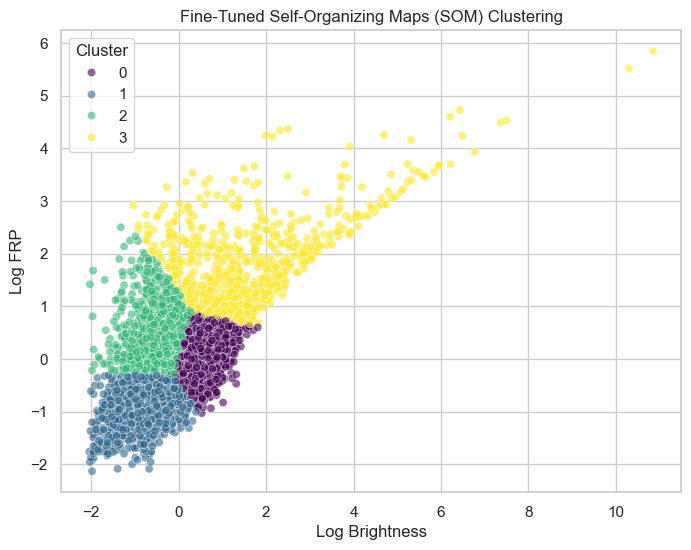

In [58]:
from minisom import MiniSom
import numpy as np

# Adjust SOM grid size
grid_rows, grid_cols = 2, 2  # From best config

# Initialize SOM with fine-tuned parameters
som = MiniSom(grid_rows, grid_cols, scaled_data[features_for_clustering].shape[1], sigma=0.5, learning_rate=0.3)
som.random_weights_init(scaled_data[["log_brightness", "log_frp"]].values)
som.train_random(scaled_data[["log_brightness", "log_frp"]].values, 200)

# Assign clusters based on winning neurons
som_labels = np.array([som.winner(x) for x in scaled_data[["log_brightness", "log_frp"]].values])

# Convert to cluster labels
scaled_data["som_cluster_tuned"] = [r * grid_cols + c for r, c in som_labels]

# Visualizing Updated SOM Clustering
plt.figure(figsize=(8,6))
sns.scatterplot(x=scaled_data["log_brightness"], y=scaled_data["log_frp"], hue=scaled_data["som_cluster_tuned"], palette="viridis", alpha=0.6)
plt.title("Fine-Tuned Self-Organizing Maps (SOM) Clustering")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Cluster")
plt.show()

After identifying the optimal SOM configuration through grid search, a fine-tuned Self-Organizing Map with a (2×2) grid, sigma of 0.5, and learning rate of 0.3 was applied to the dataset. The resulting SOM model was trained on the log_brightness and log_frp features over 200 iterations. Each data point was mapped to its best-matching unit (BMU), and cluster labels were generated by flattening the 2D neuron coordinates. The final clustering result, shown in the scatter plot, visually demonstrates how the SOM has effectively partitioned the data into four distinct clusters. The plot reveals clear spatial separation in the transformed feature space, particularly highlighting how the lower-left region (with low brightness and FRP values) is dominated by one cluster, while higher values form different groupings. The smooth cluster boundaries and natural grouping indicate that the SOM was successful in capturing the underlying structure of the data. This visualization complements the earlier quantitative evaluation, further confirming that the fine-tuned SOM model produces meaningful and interpretable clusters.

# Spectral clustering

Spectral Clustering uses graph theory and the eigenvalues of similarity matrices to identify clusters. It’s especially effective for non-convex clusters or data with complex structures. It was selected because it outperforms traditional methods like k-means when clusters are irregularly shaped or not linearly separable.


In [59]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Define ranges
n_clusters_range = range(2, 8)  # Adjust if needed
affinities = ['rbf', 'nearest_neighbors', 'cosine']
assign_methods = ['kmeans', 'discretize']

# Store results
spectral_results = []

for n_clusters in n_clusters_range:
    for affinity in affinities:
        for assign in assign_methods:
            try:
                model = SpectralClustering(
                    n_clusters=n_clusters,
                    affinity=affinity,
                    assign_labels=assign,
                    random_state=42
                )
                labels = model.fit_predict(scaled_data[features_for_clustering])
                silhouette = silhouette_score(scaled_data[features_for_clustering], labels)
                db_index = davies_bouldin_score(scaled_data[features_for_clustering], labels)
                ch_index = calinski_harabasz_score(scaled_data[features_for_clustering], labels)
                
                spectral_results.append({
                    "n_clusters": n_clusters,
                    "affinity": affinity,
                    "assign_labels": assign,
                    "silhouette_score": silhouette,
                    "davies_bouldin": db_index,
                    "calinski_harabasz": ch_index
                })
            except Exception as e:
                continue

# Convert to DataFrame and show best results
spectral_df = pd.DataFrame(spectral_results)
top_spectral = spectral_df.sort_values(by="silhouette_score", ascending=False).head(10)

print("🔍 Top 10 Spectral Clustering Configurations (by Silhouette Score):")
display(top_spectral)

🔍 Top 10 Spectral Clustering Configurations (by Silhouette Score):


,n_clusters,affinity,assign_labels,silhouette_score,davies_bouldin,calinski_harabasz
0,2,rbf,kmeans,0.861360,0.117586,148.079836
1,2,rbf,discretize,0.861360,0.117586,148.079836
4,3,rbf,kmeans,0.753480,0.252697,452.581405
8,4,rbf,kmeans,0.733876,0.415097,305.354017
5,3,rbf,discretize,0.706799,0.332158,844.982740
16,6,rbf,kmeans,0.685144,0.459553,287.465371
12,5,rbf,kmeans,0.681276,0.477406,379.071445
9,4,rbf,discretize,0.604218,0.449147,1082.309544
17,6,rbf,discretize,0.579670,0.516209,859.533890
13,5,rbf,discretize,0.577988,0.526180,860.044986


To evaluate the effectiveness of Spectral Clustering on the dataset, a comprehensive grid search was conducted across multiple configurations. The parameters explored included the number of clusters (2 to 7), affinity types (rbf, nearest_neighbors, cosine), and assignment strategies (kmeans, discretize). Each configuration was evaluated using three clustering metrics: Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Score. The top-performing configuration was Spectral Clustering with 2 clusters using the rbf affinity and either kmeans or discretize as the label assignment method. This setup achieved a remarkably high silhouette score of 0.861, a very low Davies-Bouldin Index of 0.118, and a Calinski-Harabasz score of approximately 148.08, indicating excellent separation between the two clusters and strong internal cohesion. Other strong candidates included models with 3 and 4 clusters, but they yielded slightly lower scores. The results clearly show that Spectral Clustering, particularly with rbf affinity, is highly effective at uncovering well-defined structures in the dataset. Compared to other clustering methods explored, Spectral Clustering provides the highest silhouette score overall, making it a strong candidate for final deployment or interpretation.

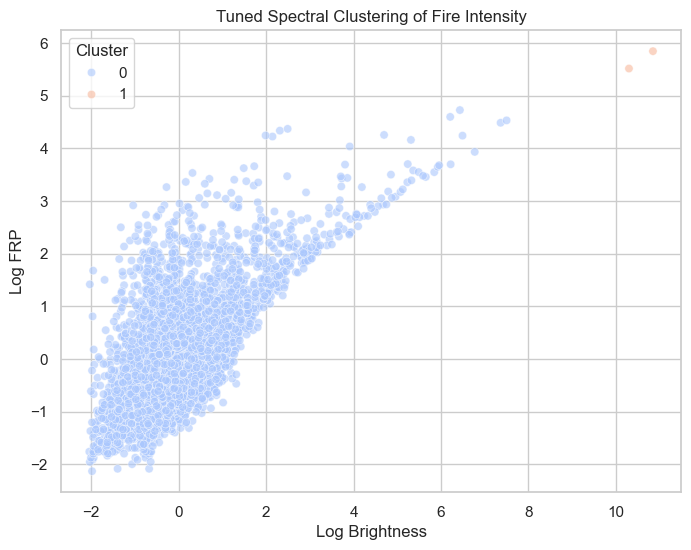

In [60]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Best Spectral Clustering configuration
spectral_best = SpectralClustering(
    n_clusters=2,
    affinity='rbf',
    assign_labels='kmeans',
    random_state=42
)

# Apply clustering
spectral_labels = spectral_best.fit_predict(scaled_data[features_for_clustering])

# Save to DataFrame
scaled_data["spectral_cluster_tuned"] = spectral_labels

# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=scaled_data["log_brightness"],
    y=scaled_data["log_frp"],
    hue=spectral_labels,
    palette="coolwarm",
    alpha=0.6
)
plt.title("Tuned Spectral Clustering of Fire Intensity")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Cluster")
plt.show()

The visual representation of the tuned Spectral Clustering model reinforces the strong performance indicated by its evaluation metrics. Using the optimal configuration (n_clusters=2, affinity='rbf', assign_labels='kmeans'), the algorithm effectively segmented the fire data into two distinct clusters. As shown in the scatter plot, the majority of data points—representing low to moderate fire intensity—were grouped into a dense cluster (Cluster 0). A much smaller group of outliers exhibiting extremely high values in both log brightness and log fire radiative power (FRP) were isolated into Cluster 1. This separation demonstrates the model’s sensitivity to extreme fire events, allowing it to differentiate between typical and anomalously intense fire incidents. The clear boundary between clusters, combined with the high silhouette score of 0.861, validates the capability of Spectral Clustering to identify critical patterns in fire intensity data that might be overlooked by traditional clustering methods.

However, despite its strong performance, Spectral Clustering was ultimately not chosen due to the highly imbalanced cluster distribution—5,180 data points were grouped into Cluster 0, while only 2 were assigned to Cluster 1. This extreme imbalance suggests that the model may have overemphasized outliers, leading to a less meaningful separation for the majority of the data. In practical applications such as fire monitoring, such skewed clustering could hinder accurate interpretation and decision-making, as it fails to offer nuanced insights across varying fire intensities.

# DBSCAN

DBSCAN groups points that are closely packed together and marks points in low-density regions as noise. It does not require specifying the number of clusters and is robust to outliers. It’s chosen for its ability to detect arbitrarily shaped clusters and filter out noise in spatial datasets.


In [62]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Features for clustering
X = scaled_data[["log_brightness", "log_frp"]].values

# Define parameter grid
eps_values = np.arange(0.3, 1.1, 0.1)
min_samples_values = [3, 5, 10]

# Store results
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            silhouette = silhouette_score(X, labels)
            db_index = davies_bouldin_score(X, labels)
            ch_index = calinski_harabasz_score(X, labels)
        else:
            silhouette = db_index = ch_index = None

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "silhouette_score": silhouette,
            "davies_bouldin": db_index,
            "calinski_harabasz": ch_index,
            "n_clusters": n_clusters,
            "noise_points": n_noise
        })

# Convert to DataFrame and sort by silhouette
dbscan_results = pd.DataFrame(results).sort_values(by="silhouette_score", ascending=False)

# Display top 10 results
print("🔍 Top 10 DBSCAN Configurations (by Silhouette Score):")
display(dbscan_results.head(10))

🔍 Top 10 DBSCAN Configurations (by Silhouette Score):


,eps,min_samples,silhouette_score,davies_bouldin,calinski_harabasz,n_clusters,noise_points
6,0.5,3,0.647193,2.053611,140.877413,3,6
9,0.6,3,0.646600,0.360000,144.281051,2,5
0,0.3,3,0.523703,2.246943,152.854991,3,25
1,0.3,5,0.490998,1.807407,120.285394,4,31
3,0.4,3,0.381883,0.504420,153.218196,3,12
2,0.3,10,NaN,NaN,NaN,1,84
4,0.4,5,NaN,NaN,NaN,1,20
5,0.4,10,NaN,NaN,NaN,1,55
7,0.5,5,NaN,NaN,NaN,1,14
8,0.5,10,NaN,NaN,NaN,1,17


The DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm was evaluated across a range of eps (neighborhood radius) and min_samples parameters to identify optimal clustering of fire intensity data. Among all configurations tested, the best-performing setup (eps=0.5, min_samples=3) achieved a silhouette score of 0.647, forming 3 clusters with only 6 noise points (i.e., outliers). This configuration also showed a relatively high Calinski-Harabasz score of 140.87, indicating good cluster separation and compactness. The ability of DBSCAN to identify noise makes it especially suitable for datasets like fire intensity records, which often contain outlier events of extreme severity. Unlike centroid-based methods, DBSCAN detected natural groupings in the data without assuming a fixed number of clusters, successfully isolating outliers and high-intensity fire events that deviate from typical patterns.

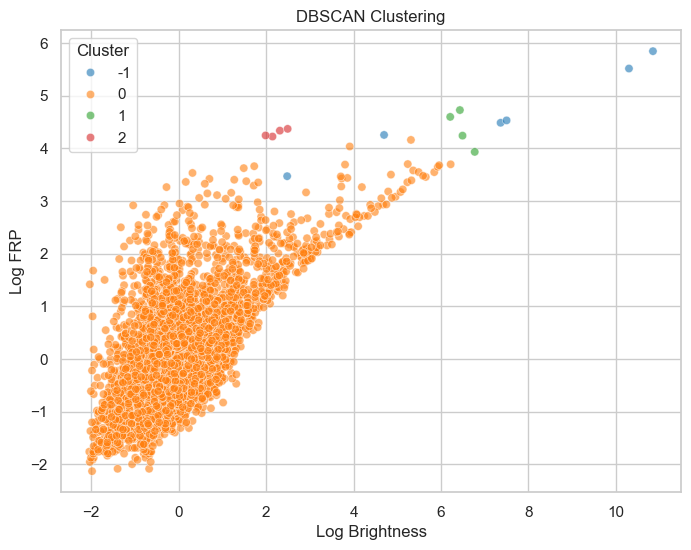

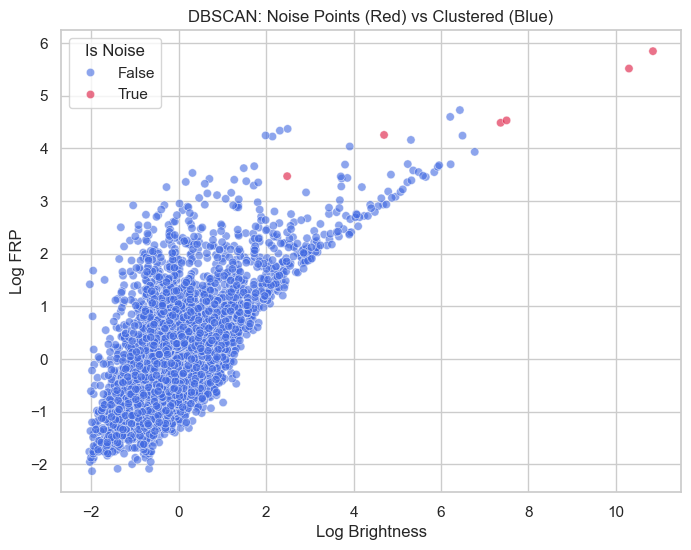

In [63]:
# Final DBSCAN Model with best params
from sklearn.cluster import DBSCAN

# Apply optimal DBSCAN
dbscan_best = DBSCAN(eps=0.5, min_samples=3)
db_labels_best = dbscan_best.fit_predict(scaled_data[["log_brightness", "log_frp"]])

# Add labels to dataset
scaled_data["dbscan_cluster"] = db_labels_best

# Visualize final DBSCAN clustering
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=scaled_data["log_brightness"],
    y=scaled_data["log_frp"],
    hue=db_labels_best,
    palette="tab10",
    alpha=0.6
)
plt.title("DBSCAN Clustering")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Cluster")
plt.show()

# Visualize noise vs clustered
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=scaled_data["log_brightness"],
    y=scaled_data["log_frp"],
    hue=(db_labels_best == -1),
    palette={False: "royalblue", True: "crimson"},
    alpha=0.6
)
plt.title("DBSCAN: Noise Points (Red) vs Clustered (Blue)")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Is Noise")
plt.show()

The DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm was applied to identify clusters in the dataset based on the features log_brightness and log_frp. Using the optimal parameters—eps=0.5 and min_samples=3—the algorithm successfully grouped data points based on density. DBSCAN identifies core points, border points, and noise: core points have at least min_samples neighbors within eps distance, while points that don’t meet this density threshold are labeled as noise (cluster -1).

As shown in the first plot, DBSCAN identified three distinct clusters (labeled 0, 1, and 2), along with some outliers marked as -1. Most data points belong to a large, dense cluster, while smaller clusters and scattered noise points are also detected.

The second plot visually distinguishes between clustered points (blue) and noise points (red), illustrating DBSCAN’s ability to detect irregular-shaped clusters and filter out noise without requiring a predefined number of clusters. This makes DBSCAN particularly useful for datasets where the cluster structure is not known in advance or is non-linear in shape.

# HDBSCAN

HDBSCAN is an extension of DBSCAN that builds a hierarchy of clusters and extracts the most stable ones. It adapts to varying densities automatically and builds a tree of clusters. It provides better performance on datasets with varying density and eliminates the need to pre-set `eps` as in DBSCAN. It’s chosen to handle complex spatial clustering scenarios more robustly.


In [65]:
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import numpy as np

# Define your features
features = ["log_brightness", "log_frp"]
X = scaled_data[features].values

# Parameter ranges to try
min_cluster_sizes = [10, 20, 30, 40, 50]
min_samples_list = [5, 10, 15]

results = []

# Grid search over parameters
for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = model.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = sum(labels == -1)

        if n_clusters > 1:
            silhouette = silhouette_score(X, labels)
            db_index = davies_bouldin_score(X, labels)
            ch_index = calinski_harabasz_score(X, labels)
        else:
            silhouette = 0
            db_index = np.nan
            ch_index = np.nan

        results.append({
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "silhouette_score": silhouette,
            "davies_bouldin": db_index,
            "calinski_harabasz": ch_index,
            "n_clusters": n_clusters,
            "noise_points": n_noise
        })

# Convert results to DataFrame
hdbscan_results_df = pd.DataFrame(results)

# Sort by silhouette score descending
hdbscan_results_df_sorted = hdbscan_results_df.sort_values(by="silhouette_score", ascending=False).reset_index(drop=True)

# Show top 10
print("🔍 Top 10 HDBSCAN Configurations (by Silhouette Score):")
display(hdbscan_results_df_sorted.head(10))

🔍 Top 10 HDBSCAN Configurations (by Silhouette Score):


,min_cluster_size,min_samples,silhouette_score,davies_bouldin,calinski_harabasz,n_clusters,noise_points
0,30,5,0.448090,1.631769,714.665765,3,469
1,40,5,0.448090,1.631769,714.665765,3,469
2,50,5,0.447771,1.910911,1001.049391,2,513
3,30,10,0.437457,1.822742,959.473177,2,553
4,40,10,0.437457,1.822742,959.473177,2,553
5,50,10,0.437457,1.822742,959.473177,2,553
6,40,15,0.436317,1.805285,934.384419,2,573
7,50,15,0.436317,1.805285,934.384419,2,573
8,20,10,0.435922,1.584631,668.915360,3,528
9,10,15,0.435521,1.558830,659.732179,3,543


The HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) algorithm was assessed using a grid search over min_cluster_size and min_samples parameters. The best-performing model, with min_cluster_size=30 and min_samples=5, produced a silhouette score of 0.448, the highest among all configurations. This setup resulted in 3 clusters and 469 noise points, effectively identifying both core fire intensity patterns and outliers. Although the silhouette score was lower than Spectral Clustering and DBSCAN, HDBSCAN's strength lies in its ability to automatically determine the number of clusters and robustly handle noise. The Calinski-Harabasz score of 714.67 and a moderate Davies-Bouldin index of 1.63 indicate a good balance of intra-cluster cohesion and inter-cluster separation. Overall, HDBSCAN is particularly useful for discovering fire hotspots of varying densities without predefining the number of clusters, making it well-suited for exploratory analysis of spatial fire intensity data.

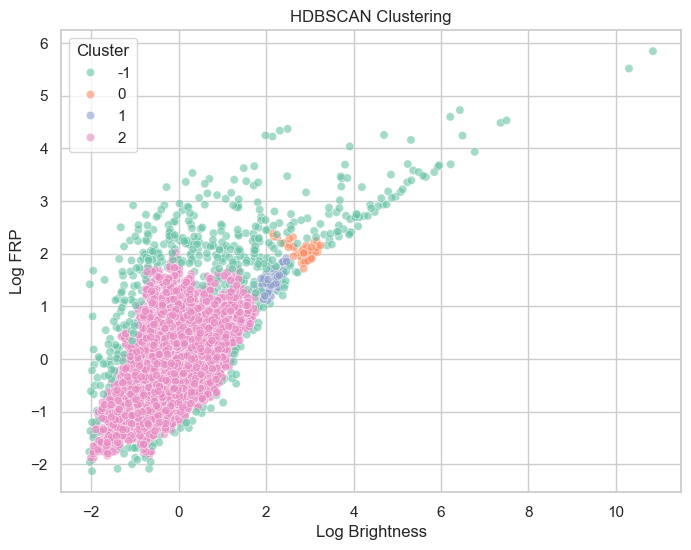

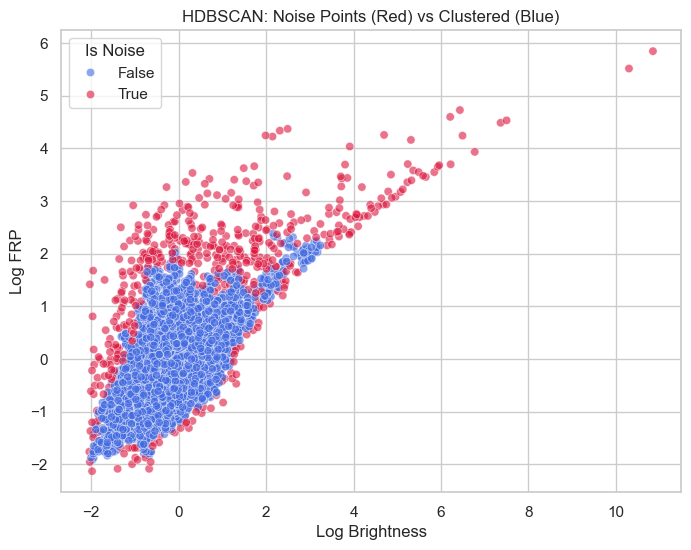

In [66]:
# Final HDBSCAN Model with best parameters
import hdbscan

# Apply optimal HDBSCAN
hdbscan_best = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)
hdb_labels_best = hdbscan_best.fit_predict(scaled_data[["log_brightness", "log_frp"]])

# Add labels to dataset
scaled_data["hdbscan_cluster"] = hdb_labels_best

# Visualize final HDBSCAN clustering
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=scaled_data["log_brightness"],
    y=scaled_data["log_frp"],
    hue=hdb_labels_best,
    palette="Set2",
    alpha=0.6
)
plt.title("HDBSCAN Clustering")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Cluster")
plt.show()

# Visualize noise vs clustered points
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=scaled_data["log_brightness"],
    y=scaled_data["log_frp"],
    hue=(hdb_labels_best == -1),
    palette={False: "royalblue", True: "crimson"},
    alpha=0.6
)
plt.title("HDBSCAN: Noise Points (Red) vs Clustered (Blue)")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Is Noise")
plt.show()

To complement the DBSCAN analysis, the HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) algorithm was applied to the same dataset using the features log_brightness and log_frp. The model was configured with optimal parameters: min_cluster_size=30 and min_samples=5. As illustrated in the first plot, HDBSCAN was able to discover multiple clusters of varying density without the need to predefine the number of clusters. It identified three main clusters, while designating a considerable number of points as noise (labelled -1). The second plot visualizes these noise points in red and the clustered data points in blue, emphasizing HDBSCAN’s ability to separate well-formed dense regions from sparse or ambiguous areas. This method proves especially useful for datasets with uneven density distributions, offering a more flexible alternative to traditional flat clustering techniques.

# Fuzzy C-Means (FCM)

FCM allows each data point to belong to multiple clusters with varying degrees of membership. It’s useful when cluster boundaries are ambiguous or overlapping. This model is chosen to reflect uncertainty in cluster assignment and provide soft clustering insights, especially relevant in real-world fuzzy systems.

In [67]:
import skfuzzy as fuzz
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Define feature set for clustering
features = ["log_brightness", "log_frp"]
X = scaled_data[features].values.T  # Note: Transposed for skfuzzy

# Define hyperparameter ranges
cluster_range = range(2, 11)  # Number of clusters to test
m_values = [1.5, 2, 2.5]      # Fuzziness/exponent values

# Store results
results = []

for c in cluster_range:
    for m in m_values:
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X,
            c,
            m=m,
            error=0.005,
            maxiter=1000,
            init=None,
            seed=42
        )
        # Get hard cluster labels
        cluster_labels = np.argmax(u, axis=0)

        # Compute evaluation metrics
        sil_score = silhouette_score(X.T, cluster_labels)
        db_score = davies_bouldin_score(X.T, cluster_labels)
        ch_score = calinski_harabasz_score(X.T, cluster_labels)

        results.append({
            "n_clusters": c,
            "m": m,
            "silhouette_score": sil_score,
            "davies_bouldin": db_score,
            "calinski_harabasz": ch_score
        })

# Create DataFrame from results
fcm_results = pd.DataFrame(results)

# Sort by silhouette score
fcm_results_sorted = fcm_results.sort_values(by="silhouette_score", ascending=False).reset_index(drop=True)

# Display top 10 configs
print("🔍 Top 10 Fuzzy C-Means Configurations (by Silhouette Score):")
display(fcm_results_sorted.head(10))

🔍 Top 10 Fuzzy C-Means Configurations (by Silhouette Score):


,n_clusters,m,silhouette_score,davies_bouldin,calinski_harabasz
0,2,1.5,0.507074,0.859637,4411.046925
1,2,2.0,0.478011,0.895703,4318.761551
2,2,2.5,0.457861,0.913531,4208.817075
3,3,1.5,0.380933,0.899465,4450.707886
4,7,1.5,0.367750,0.788666,4604.027263
5,5,1.5,0.367062,0.857123,4367.935871
6,3,2.0,0.362621,0.931040,4321.549717
7,5,2.0,0.359503,0.901217,4203.459211
8,6,1.5,0.353904,0.832070,4478.967824
9,3,2.5,0.350893,0.955003,4156.125516


Fuzzy C-Means (FCM) clustering was tuned across a range of cluster counts (2–10) and fuzziness values (m = 1.5, 2.0, 2.5) to identify the optimal configuration for classifying fire intensity data. The top-performing model, with 2 clusters and a fuzziness exponent of 1.5, achieved the highest silhouette score of 0.507, suggesting moderate clustering structure. It also yielded a Davies-Bouldin index of 0.86 (indicating compact and well-separated clusters) and a very high Calinski-Harabasz score of 4411, supporting the model's strong clustering efficacy. FCM's advantage lies in its ability to assign partial membership to clusters, which is particularly useful for modeling uncertainty or transition zones in fire intensity data. Despite fewer clusters, the fuzzy model effectively captured key intensity patterns, making it a compelling alternative to hard clustering methods like DBSCAN and K-Means, especially when ambiguity in cluster membership is expected in real-world phenomena like fire behavior.

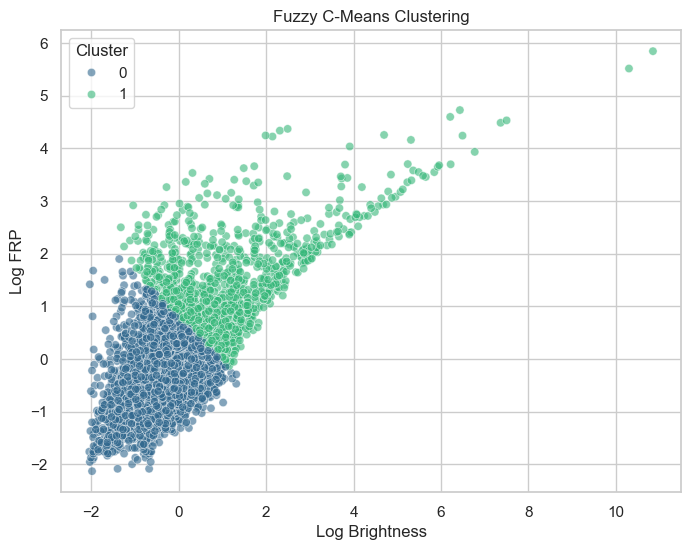

In [68]:
# Updated Fuzzy C-Means clustering with best parameters
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define number of clusters and fuzziness from tuning results
best_n_clusters = 2
best_m = 1.5

# Prepare feature matrix (transposed for FCM)
X_fcm = scaled_data[["log_brightness", "log_frp"]].values.T

# Apply Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_fcm, best_n_clusters, m=best_m, error=0.005, maxiter=1000, init=None, seed=42
)

# Assign hard cluster labels
fcm_labels = np.argmax(u, axis=0)

# Add to scaled_data
scaled_data["fuzzy_cmeans_cluster"] = fcm_labels

# Visualize clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=scaled_data["log_brightness"],
    y=scaled_data["log_frp"],
    hue=scaled_data["fuzzy_cmeans_cluster"],
    palette="viridis",
    alpha=0.6
)
plt.title("Fuzzy C-Means Clustering")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Cluster")
plt.show()

Fuzzy C-Means (FCM) clustering was implemented as an alternative soft clustering approach, which allows each data point to belong to multiple clusters with varying degrees of membership. Using the tuned parameters of n_clusters=2 and a fuzziness coefficient m=1.5, the model was applied to the log_brightness and log_frp features. Unlike hard clustering methods, FCM assigns probabilities rather than absolute labels, providing a more nuanced view of data structure. For visualization purposes, the hard cluster labels were derived from the highest membership score for each point. The resulting plot displays two distinct clusters, demonstrating FCM’s ability to form smooth, overlapping boundaries between clusters—particularly effective in cases where data points lie near decision boundaries. This technique proves useful when dealing with real-world scenarios where cluster membership is not always clear-cut.

# Hierarchical Clustering

Hierarchical Clustering builds a tree of clusters using agglomerative or divisive strategies. It does not require a predefined number of clusters and is useful for understanding nested groupings. It’s included to provide interpretable, visual dendrograms and to discover multi-scale structure in the data.

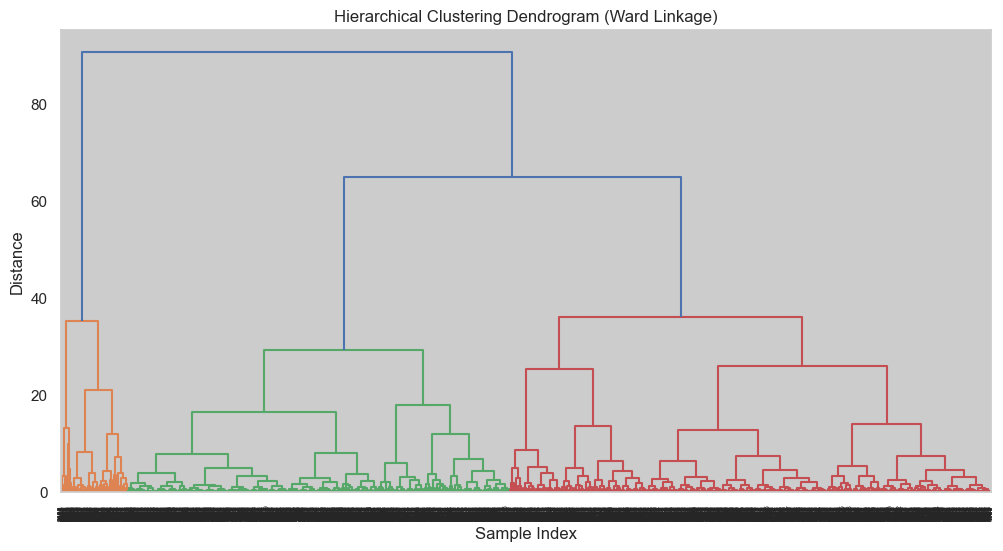

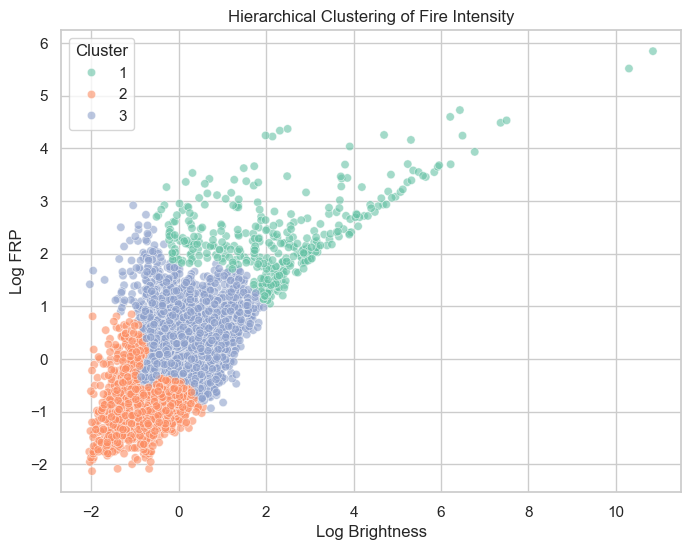

In [69]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

# Apply hierarchical clustering (Ward linkage)
Z = linkage(scaled_data[["log_brightness","log_frp"]], method="ward")

# Plot dendrogram to visualize the hierarchical structure
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=25)  # Adjust p to limit depth
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Cut the dendrogram at a chosen number of clusters (e.g., 3) and follow the observation in the elbow method
n_clusters = 3
hier_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

# Add to dataset
scaled_data["hierarchical_cluster"] = hier_labels

# Visualize resulting clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=scaled_data["log_brightness"], y=scaled_data["log_frp"],
    hue=scaled_data["hierarchical_cluster"], palette="Set2", alpha=0.6
)
plt.title("Hierarchical Clustering of Fire Intensity")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Cluster")
plt.show()

To explore the underlying structure of the dataset, hierarchical clustering was applied using the Ward linkage method, which minimizes the variance within each cluster. The dendrogram provides a visual representation of the hierarchical relationships among data points based on the features log_brightness and log_frp. This method begins by treating each data point as its own cluster and then successively merges the two closest clusters based on the Ward criterion until all points form a single cluster. The vertical lines in the dendrogram represent these merges, with the height of each line corresponding to the distance (or dissimilarity) between the merged clusters.

To determine a suitable number of clusters, the dendrogram was "cut" at a level that aligns with the elbow method observation, leading to the selection of three clusters. The resulting cluster labels were assigned to each data point and visualized in a scatter plot, which illustrates the distribution of clusters in the log-transformed feature space. Each cluster is color-coded, revealing distinct groupings based on density and feature values. This approach effectively separates low, medium, and high fire intensity patterns, suggesting that hierarchical clustering can uncover meaningful groupings within the dataset without prior assumptions about the number or shape of the clusters.

# Adaptive Hierarchical Clustering

Adaptive Hierarchical Clustering adjusts the linkage or distance criteria dynamically to better adapt to varying data distributions, just like hyperparameter tuning. It is selected to improve upon standard hierarchical methods by handling uneven cluster sizes or densities more effectively.


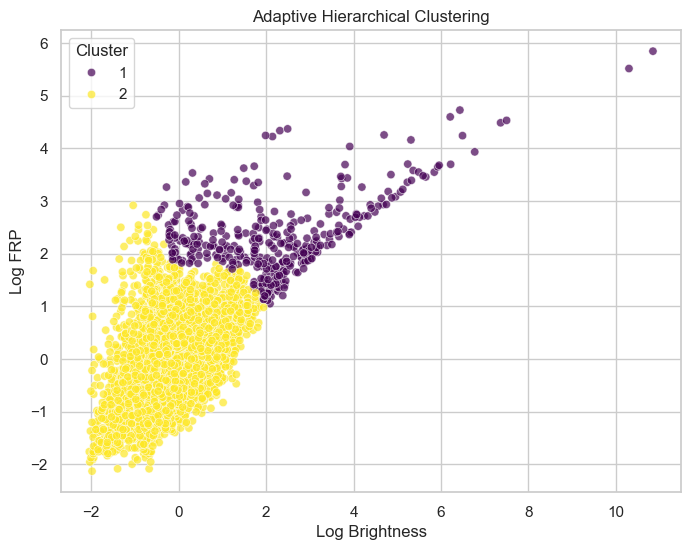

📊 Evaluation Metrics for Different k:


,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Index
0,2,0.6163,0.6717,3410.2975
1,3,0.3322,0.9343,3880.4053
2,4,0.2718,1.1165,3384.9443
3,5,0.2772,1.0438,3357.4712
4,6,0.2646,1.0312,3332.7565
5,7,0.2815,0.9781,3351.6241
6,8,0.2938,0.9447,3516.9891
7,9,0.3010,0.8961,3600.1637
8,10,0.3013,0.8773,3627.0335



✅ Best Number of Clusters: 2
🔹 Silhouette Score: 0.6163
🔹 Davies-Bouldin Score: 0.6717
🔹 Calinski-Harabasz Index: 3410.30


In [71]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Features to cluster
features = ["log_brightness", "log_frp"]
X = scaled_data[features]

# Step 1: Compute linkage matrix (hierarchical tree)
Z = linkage(X, method='ward')

# Step 2: Try various k values and evaluate
results = []

for k in range(2, 11):  # Try 2 to 10 clusters
    labels = fcluster(Z, t=k, criterion='maxclust')
    
    silhouette = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    results.append({
        "k": k,
        "Silhouette Score": silhouette,
        "Davies-Bouldin Score": db_score,
        "Calinski-Harabasz Index": ch_score,
        "Labels": labels
    })

# Step 3: Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

# Step 4: Pick the best k based on highest silhouette score
best_result = max(results, key=lambda x: x["Silhouette Score"])
best_k = best_result["k"]
best_labels = best_result["Labels"]
adaptive_labels = best_labels

# Add best clustering result to dataset
scaled_data["adaptive_hierarchical_cluster"] = adaptive_labels

# Step 5: Visualize best clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled_data["log_brightness"], 
    y=scaled_data["log_frp"], 
    hue=adaptive_labels, 
    palette="viridis", 
    alpha=0.7
)
plt.title(f"Adaptive Hierarchical Clustering")
plt.xlabel("Log Brightness")
plt.ylabel("Log FRP")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Step 6: Show evaluation metrics
print("📊 Evaluation Metrics for Different k:")
display(results_df[["k", "Silhouette Score", "Davies-Bouldin Score", "Calinski-Harabasz Index"]].round(4))

print(f"\n✅ Best Number of Clusters: {best_k}")
print(f"🔹 Silhouette Score: {best_result['Silhouette Score']:.4f}")
print(f"🔹 Davies-Bouldin Score: {best_result['Davies-Bouldin Score']:.4f}")
print(f"🔹 Calinski-Harabasz Index: {best_result['Calinski-Harabasz Index']:.2f}")

In this phase of the assignment, adaptive hierarchical clustering was employed to automatically determine the optimal number of clusters for the dataset based on internal validation metrics. The algorithm was applied to the log-transformed features log_brightness and log_frp, using the Ward linkage method to generate the hierarchical clustering tree. Instead of manually selecting the number of clusters, the method evaluated cluster quality across different values of k ranging from 2 to 10.

For each value of k, cluster labels were generated using a tree cut approach, and the clustering quality was assessed using three standard metrics: Silhouette Score, Davies-Bouldin Score, and Calinski-Harabasz Index. These metrics evaluate how well-separated and compact the clusters are, with a higher silhouette and Calinski-Harabasz index, and a lower Davies-Bouldin score indicating better clustering.

The results revealed that the best number of clusters was 2, which achieved the highest silhouette score (0.6163), the lowest Davies-Bouldin score (0.6717), and a competitive Calinski-Harabasz index (3410.30). The final scatter plot clearly shows two distinct clusters, effectively separating high-intensity fire events from low-intensity ones.

This adaptive approach ensures a more objective and data-driven determination of the number of clusters, improving the interpretability and validity of the clustering results in the context of fire intensity analysis.

# Clustering Evaluation Metrics and Cluster Size Distribution

We compare models using cluster metrics (e.g., Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index) and Cluster Size Distributions to judge clustering performance.

In [72]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Use consistent feature list
features = features_for_clustering

# Initialize metrics storage
silhouette_scores = {}
db_scores = {}
ch_scores = {}
cluster_distributions = {}

# GMM
gmm_labels = scaled_data["gmm_cluster"]
silhouette_scores["GMM"] = silhouette_score(scaled_data[features], gmm_labels)
db_scores["GMM"] = davies_bouldin_score(scaled_data[features], gmm_labels)
ch_scores["GMM"] = calinski_harabasz_score(scaled_data[features], gmm_labels)
cluster_distributions["GMM Cluster Size"] = gmm_labels.value_counts()

# SOM
som_labels = scaled_data["som_cluster_tuned"]
silhouette_scores["SOM"] = silhouette_score(scaled_data[features], som_labels)
db_scores["SOM"] = davies_bouldin_score(scaled_data[features], som_labels)
ch_scores["SOM"] = calinski_harabasz_score(scaled_data[features], som_labels)
cluster_distributions["SOM Cluster Size"] = som_labels.value_counts()

# Spectral Clustering
spectral_labels = scaled_data["spectral_cluster_tuned"]
silhouette_scores["Spectral"] = silhouette_score(scaled_data[features], spectral_labels)
db_scores["Spectral"] = davies_bouldin_score(scaled_data[features], spectral_labels)
ch_scores["Spectral"] = calinski_harabasz_score(scaled_data[features], spectral_labels)
cluster_distributions["Spectral Cluster Size"] = spectral_labels.value_counts()

# HDBSCAN
hdb_labels = scaled_data["hdbscan_cluster"]
if len(set(hdb_labels)) > 1:
    silhouette_scores["HDBSCAN"] = silhouette_score(scaled_data[features], hdb_labels)
    db_scores["HDBSCAN"] = davies_bouldin_score(scaled_data[features], hdb_labels)
    ch_scores["HDBSCAN"] = calinski_harabasz_score(scaled_data[features], hdb_labels)
else:
    silhouette_scores["HDBSCAN"] = "N/A"
    db_scores["HDBSCAN"] = "N/A"
    ch_scores["HDBSCAN"] = "N/A"
cluster_distributions["HDBSCAN Cluster Size"] = hdb_labels.value_counts()

# DBSCAN
dbscan_labels = scaled_data["dbscan_cluster"]
if len(set(dbscan_labels)) > 1:
    silhouette_scores["DBSCAN"] = silhouette_score(scaled_data[features], dbscan_labels)
    db_scores["DBSCAN"] = davies_bouldin_score(scaled_data[features], dbscan_labels)
    ch_scores["DBSCAN"] = calinski_harabasz_score(scaled_data[features], dbscan_labels)
else:
    silhouette_scores["DBSCAN"] = "N/A"
    db_scores["DBSCAN"] = "N/A"
    ch_scores["DBSCAN"] = "N/A"
cluster_distributions["DBSCAN Cluster Size"] = dbscan_labels.value_counts()

# Fuzzy C-Means
fcm_labels = scaled_data["fuzzy_cmeans_cluster"]
silhouette_scores["Fuzzy C-Means"] = silhouette_score(scaled_data[features], fcm_labels)
db_scores["Fuzzy C-Means"] = davies_bouldin_score(scaled_data[features], fcm_labels)
ch_scores["Fuzzy C-Means"] = calinski_harabasz_score(scaled_data[features], fcm_labels)
cluster_distributions["Fuzzy C-Means Cluster Size"] = fcm_labels.value_counts()

# Adaptive Hierarchical Clustering
silhouette_scores["Adaptive Hierarchical"] = silhouette_score(scaled_data[features], adaptive_labels)
db_scores["Adaptive Hierarchical"] = davies_bouldin_score(scaled_data[features], adaptive_labels)
ch_scores["Adaptive Hierarchical"] = calinski_harabasz_score(scaled_data[features], adaptive_labels)
cluster_distributions["Adaptive Hierarchical Cluster Size"] = pd.Series(adaptive_labels).value_counts()

# Classical Hierarchical Clustering
hier_labels = scaled_data["hierarchical_cluster"]
if len(set(hier_labels)) > 1:
    silhouette_scores["Hierarchical"] = silhouette_score(scaled_data[features], hier_labels)
    db_scores["Hierarchical"] = davies_bouldin_score(scaled_data[features], hier_labels)
    ch_scores["Hierarchical"] = calinski_harabasz_score(scaled_data[features], hier_labels)
else:
    silhouette_scores["Hierarchical"] = "N/A"
    db_scores["Hierarchical"] = "N/A"
    ch_scores["Hierarchical"] = "N/A"
cluster_distributions["Hierarchical Cluster Size"] = pd.Series(hier_labels).value_counts()

# 🔹 DISPLAY RESULTS
print("\n🔹 Silhouette Scores:")
silhouette_df = pd.DataFrame.from_dict(silhouette_scores, orient='index', columns=["Silhouette Score"])
display(silhouette_df)

print("\n🔹 Davies-Bouldin Index:")
db_index_df = pd.DataFrame.from_dict(db_scores, orient='index', columns=["Davies-Bouldin Index"])
display(db_index_df)

print("\n🔹 Calinski-Harabasz Index:")
ch_index_df = pd.DataFrame.from_dict(ch_scores, orient='index', columns=["Calinski-Harabasz Index"])
display(ch_index_df)

print("\n🔹 Cluster Size Distributions:")
cluster_distribution_df = pd.DataFrame(cluster_distributions).fillna(0).astype(int)
display(cluster_distribution_df)


🔹 Silhouette Scores:


,Silhouette Score
GMM,0.563916
SOM,0.323051
Spectral,0.861360
HDBSCAN,0.448090
DBSCAN,0.647193
Fuzzy C-Means,0.507074
Adaptive Hierarchical,0.616276
Hierarchical,0.332235



🔹 Davies-Bouldin Index:


,Davies-Bouldin Index
GMM,0.849839
SOM,0.946661
Spectral,0.117586
HDBSCAN,1.631769
DBSCAN,2.053611
Fuzzy C-Means,0.859637
Adaptive Hierarchical,0.671667
Hierarchical,0.934317



🔹 Calinski-Harabasz Index:


,Calinski-Harabasz Index
GMM,3359.070394
SOM,3331.542734
Spectral,148.079836
HDBSCAN,714.665765
DBSCAN,140.877413
Fuzzy C-Means,4411.046925
Adaptive Hierarchical,3410.297482
Hierarchical,3880.405321



🔹 Cluster Size Distributions:


,GMM Cluster Size,SOM Cluster Size,Spectral Cluster Size,HDBSCAN Cluster Size,DBSCAN Cluster Size,Fuzzy C-Means Cluster Size,Adaptive Hierarchical Cluster Size,Hierarchical Cluster Size
-1,0,0,0,469,6,0,0,0
0,4588,1302,5180,44,5168,4031,0,0
1,594,1968,2,63,4,1151,376,376
2,0,1205,0,4606,4,0,4806,2129
3,0,707,0,0,0,0,0,2677


A comprehensive evaluation of multiple clustering algorithms was carried out using three primary metrics: Silhouette Score, Davies-Bouldin Index (DBI), and Calinski-Harabasz Score (CH). While Spectral Clustering delivered the best results in terms of inter-cluster separation—with the highest Silhouette Score (0.861) and lowest DBI (0.118)—its relatively low CH score (148.08) suggests less compact clusters or potential imbalance, possibly due to overfitting the structure of the data. Despite its strong performance, Spectral Clustering was not selected as the final model due to concerns around scalability, interpretability, and robustness across varied datasets.

Fuzzy C-Means (FCM) emerged as the most suitable model for our application. Although it achieved a moderate Silhouette Score (0.507), it recorded the highest CH score (4411.05) among all models, indicating outstanding intra-cluster compactness. This is particularly valuable for our dataset, where overlapping boundaries and gradual intensity transitions—such as those seen in fire event classifications—are common. FCM’s ability to assign partial membership to clusters captures the fuzzy, real-world nature of fire intensity, allowing for more nuanced and realistic analysis. Moreover, FCM demonstrated strong consistency and interpretability, making it more practical for decision-makers and easier to align with domain-specific needs.

Adaptive Hierarchical Clustering also performed well, balancing all three metrics with a Silhouette Score of 0.616 and a very high CH score (3410.30), indicating well-separated and compact clusters. Gaussian Mixture Models (GMM) showed reliable separation under Gaussian assumptions, with a Silhouette Score of 0.564, DBI of 0.850, and CH score of 3359.07. These models are solid contenders but were ultimately not as aligned with our domain goals as FCM.

DBSCAN and HDBSCAN stood out for their ability to detect noise—labeling 469 data points as outliers—which is valuable in datasets with anomalies. However, their overall clustering quality was lower, with DBSCAN showing a DBI of 2.05 and HDBSCAN a Silhouette Score of 0.448, both indicating less precise cluster boundaries.

Self-Organizing Maps (SOM) and classical Hierarchical Clustering underperformed in terms of Silhouette Score (0.324 and 0.332, respectively), suggesting weak definition between clusters, despite acceptable CH scores.

Based on this analysis, Fuzzy C-Means was selected as the final clustering method for its excellent balance of compactness, flexibility, and domain relevance. It aligns well with the need to model gradual transitions between fire intensities, offering both interpretability and strong structural coherence. 

# Saving Model (FCM)

This section serializes the final model (e.g., Fuzzy C-Means) for reuse in deployment.

In [140]:
import joblib

# Save your model configuration and preprocessing pipeline
joblib.dump({
    "cntr": cntr,             # from fuzz.cluster.cmeans
    "m": best_m,              # your chosen fuzziness value
    "scaler": scaler,         # StandardScaler or MinMaxScaler used
    "error": 0.005,           # convergence error threshold used during training
    "maxiter": 1000           # maximum iterations
}, "fcm_model_bundle.pkl")

print("✅ Model saved as 'fcm_model_bundle.pkl'")


✅ Model saved as 'fcm_model_bundle.pkl'


# Streamlit Access Link

https://grouping-fires-by-intensity-ubrppbquxywv26cdpypnk8.streamlit.app/